In [ ]:
%matplotlib notebook
import numpy as np
from matplotlib.pyplot import *
from numba import jit
from scipy.special import erf
from numba import jit

In [ ]:
def sigma2_hat(eps, N):
    m = np.arange(1,N)
    num = (N-0.5)**2 - 2*(m*erf(m*eps/np.sqrt(2))).sum()
    ##num = (N-0.5)**2 - 2*(m*erf(m*eps/np.sqrt(2))).sum()
    denom = 2.0/np.pi * (0.5 + (np.exp(-1.0*(m**2)*(eps**2)/2.0)).sum() )**2
    ##denom = 2.0/np.pi*(0.5 + (np.exp(-m*m*ep*ep/2.0)).sum() )**2
    var = num/denom
    return var

In [ ]:
N = 2**6/2
m = np.arange(1,N)
eps_arr = 1/np.arange(2**0.25,2*N,0.1)

In [ ]:
var_set = []
for ep in eps_arr:
    var_set.append(sigma2_hat(ep,N))
    

No handles with labels found to put in legend.


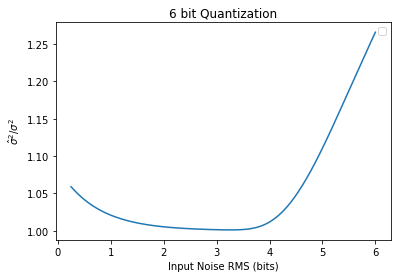

In [ ]:
figure()
plot(np.log2(1.0/eps_arr),var_set)
title('6 bit Quantization')
xlabel('Input Noise RMS (bits)')
#ylabel("Increase in Variance")
ylabel(r'$\hat{\sigma}^2$/$\sigma^2$')
legend()

In [ ]:
 @jit
def quantizer(a, nbits=8):
    # a assumed to be signal in 'lsb's' but continuous
    nlevels = 2**nbits
    max_high = nlevels/2 - 1
    max_low = -1.0*nlevels/2
    quantized_a = np.round(a,0)
    high_mask = (quantized_a > max_high)
    quantized_a[high_mask] = max_high
    low_mask = (quantized_a < max_low)
    quantized_a[low_mask] = max_low
    #at_high = (quantized_a == max_high)
    #at_low = (quantized_a == max_low)
    #saturation_percent = 100*(sum(high_mask) + sum(low_mask))/len(quantized_a)
    #print("saturation percent " + str(saturation_percent))
    #print("too high vs at high ratio:" + str(sum(at_high)/(sum(at_high)+sum(high_mask))))
    return quantized_a
    

In [ ]:
signal = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)

In [ ]:
noise_term = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)
noise_term_off = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)

In [ ]:
gain = 15

In [ ]:
f_signal_on = signal + noise_term/gain  #this way to make quantization easier
f_signal_off = noise_term_off/gain

In [ ]:
q_signal_on = quantizer(f_signal_on, nbits=8)
q_signal_off = quantizer(f_signal_off, nbits=8)

<ipython-input-6-6e43e1128abb>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "quantizer" failed type inference due to: No implementation of function Function(<function round_ at 0x7fb8fc10fc10>) found for signature:
 
 >>> round_(array(complex128, 1d, C), Literal[int](0))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload of function 'round_': File: numba/core/typing/npydecl.py: Line 1073.
    With argument(s): '(array(complex128, 1d, C), int64)':
   No match.

During: resolving callee type: Function(<function round_ at 0x7fb8fc10fc10>)
During: typing of call at <ipython-input-6-6e43e1128abb> (7)


File "<ipython-input-6-6e43e1128abb>", line 7:
def quantizer(a, nbits=8):
    <source elided>
    max_low = -1.0*nlevels/2
    quantized_a = np.round(a,0)
    ^

  @jit
/home/kbandura/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "quantizer" was 

In [ ]:
auto_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:10000])*np.conjugate(np.fft.fft(q_signal_on[:10000])))
auto_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:10000])*np.conjugate(np.fft.fft(q_signal_off[:10000])))

<IPython.core.display.Javascript object>


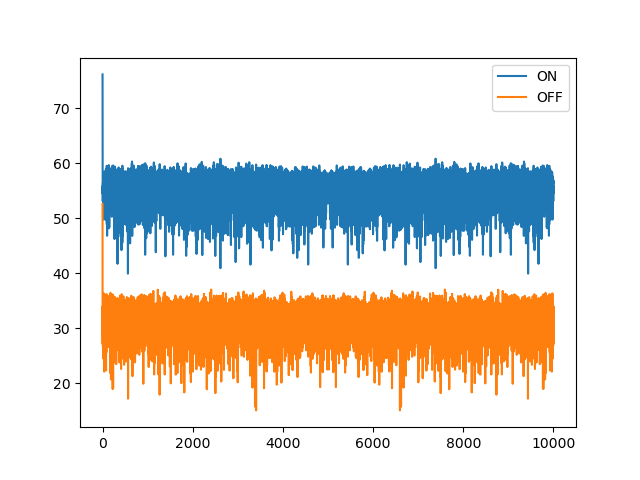

In [ ]:
figure()
plot(10*np.log10(np.abs(auto_corr_on)), label="ON")
plot(10*np.log10(np.abs(auto_corr_off)), label="OFF")
#plot(10*np.log10(np.real(auto_corr1)))
#plot(10*np.log10(np.imag(auto_corr1)))
legend()

In [ ]:
cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:10000])*np.conjugate(np.fft.fft(signal[:10000])))
cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:10000])*np.conjugate(np.fft.fft(signal[:10000])))

<IPython.core.display.Javascript object>


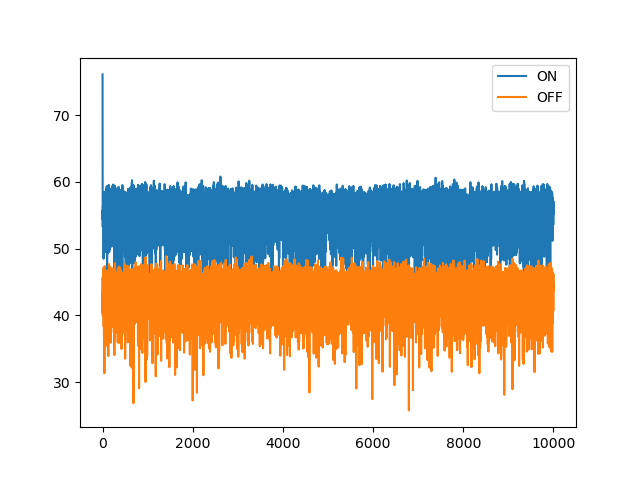

In [ ]:
figure()
plot(10*np.log10(np.abs(cross_corr_on)), label='ON')
plot(10*np.log10(np.abs(cross_corr_off)), label="OFF")
legend()

In [ ]:
print(abs(auto_corr_on.mean())/abs(np.mean(auto_corr_off)))

177.8659421312635


In [ ]:
print(abs(cross_corr_on.max())/abs(np.mean(cross_corr_off)))

990573.5793966075


In [ ]:
print(abs(auto_corr_on.max())/abs(np.std(auto_corr_on)))

71.12528587557098


In [ ]:
print(abs(cross_corr_on[0])/abs(cross_corr_off[0]))

4032.0254772826834


In [ ]:
print(abs(auto_corr_on[0])/abs(auto_corr_off[0]))

227.50685914153686


In [ ]:
gains = np.arange(0.1,10,0.2)

In [ ]:
snr_cross = []
snr_cross_no_quant = []
snr_auto = []
stop_time = 100000
#prob should actually regenerate noise...
#but when thats included, the scaling just looks random almost.  Highly dependent on the actual correlation of the off noise
for gain in gains:
    #signal = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)
    #noise_term = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)
    #noise_term_off = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)
    f_signal_on = signal + noise_term/gain  #this way to make quantization easier
    f_signal_off = noise_term_off/gain
    q_signal_on = quantizer(f_signal_on, nbits=8)
    q_signal_off = quantizer(f_signal_off, nbits=8)
    #q_signal_on = f_signal_on
    #q_signal_off = f_signal_off
    auto_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(q_signal_on[:stop_time])))
    auto_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(q_signal_off[:stop_time])))
    cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_on_no_quant = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_off_no_quant = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    snr_cross_no_quant1 = abs(cross_corr_on_no_quant[0])/abs(cross_corr_off_no_quant[0])
    snr_cross1 = abs(cross_corr_on[0])/abs(cross_corr_off[0])
    snr_auto1 = abs(auto_corr_on[0])/abs(auto_corr_off[0])
    snr_cross.append(snr_cross1)
    snr_auto.append(snr_auto1)
    snr_cross_no_quant.append(snr_cross_no_quant1)
    print("gain {}, snr auto= {}, snr_cross={}, snr_cross_no_quant={}".format(gain, snr_auto1, snr_cross1, snr_cross_no_quant1))

gain 0.1, snr auto= 0.9850560546766358, snr_cross=15.44804114004336, snr_cross_no_quant=51.42871644008626
gain 0.30000000000000004, snr auto= 1.0316324877981224, snr_cross=77.02922527622539, snr_cross_no_quant=154.96326725769865
gain 0.5000000000000001, snr auto= 1.1476587446263944, snr_cross=182.68445229173986, snr_cross_no_quant=258.5124298345386
gain 0.7000000000000001, snr auto= 1.3632718137382314, snr_cross=270.2145768630846, snr_cross_no_quant=362.06366762491336
gain 0.9000000000000001, snr auto= 1.684410809784619, snr_cross=407.34887370755445, snr_cross_no_quant=465.6155960707504
gain 1.1000000000000003, snr auto= 2.097737914262893, snr_cross=548.4179848026496, snr_cross_no_quant=569.167838207595
gain 1.3000000000000003, snr auto= 2.590475161335974, snr_cross=656.2042839286005, snr_cross_no_quant=672.7202491755121
gain 1.5000000000000004, snr auto= 3.159684933757995, snr_cross=763.9869592453979, snr_cross_no_quant=776.2727614098608
gain 1.7000000000000004, snr auto= 3.8037603119

<IPython.core.display.Javascript object>


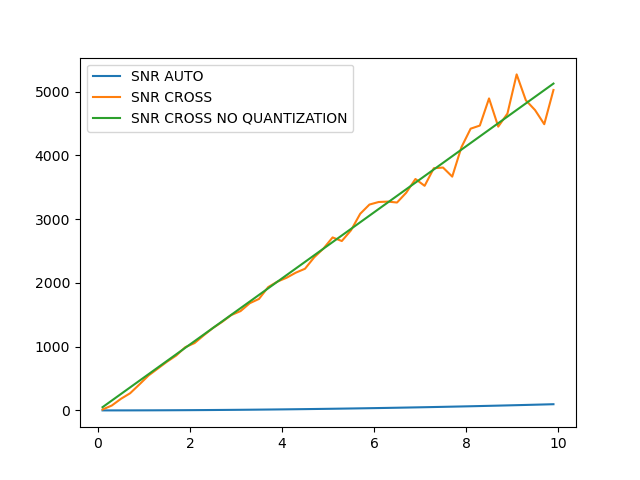

In [ ]:
figure()
plot(gains, snr_auto, label='SNR AUTO')
plot(gains, snr_cross, label="SNR CROSS")
plot(gains, snr_cross_no_quant, label="SNR CROSS NO QUANTIZATION")
legend()

<IPython.core.display.Javascript object>


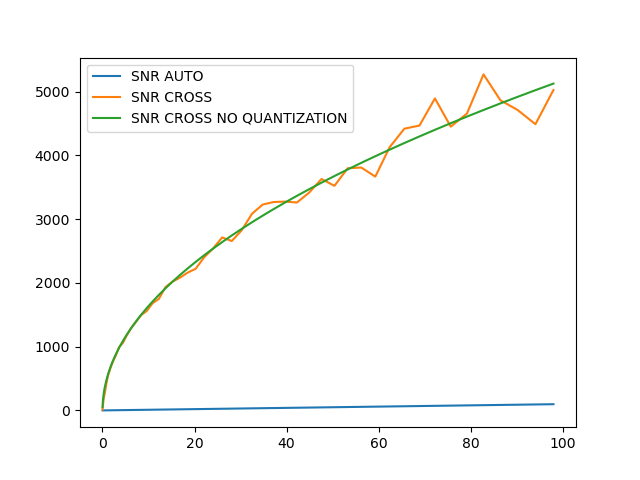

In [ ]:
figure()
plot(gains*gains, snr_auto, label='SNR AUTO')
plot(gains*gains, snr_cross, label="SNR CROSS")
plot(gains*gains, snr_cross_no_quant, label="SNR CROSS NO QUANTIZATION")
legend()

<IPython.core.display.Javascript object>


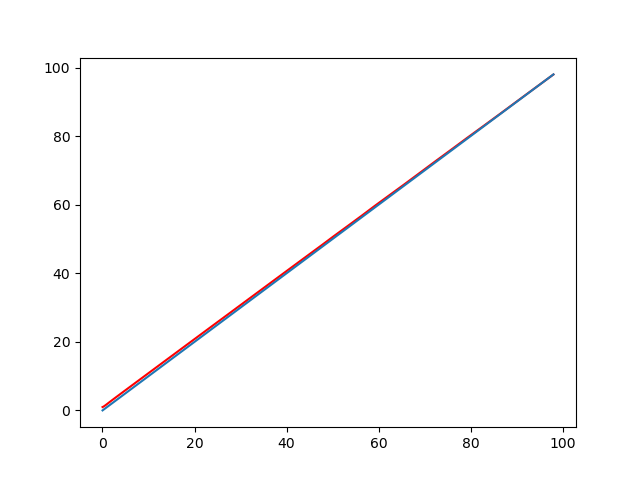

In [ ]:
figure()
plot(gains*gains, snr_auto, color = 'red')
plot(gains*gains, gains*gains)
#SNR scales with power gain.

In [ ]:
snr_cross_w_int = []
snr_cross_no_quant_w_int = []
snr_auto_w_int = []
stop_times = np.arange(5000,100000,5000)
gain=5.0
#prob should actually regenerate noise...
#make some fuctnios.
for stop_time in stop_times:
    #signal = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)
    #noise_term = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)
    #noise_term_off = np.random.normal(0, 2**5.5, 100000) +1.0j*np.random.normal(0, 2**5.5, 100000)
    f_signal_on = signal + noise_term/gain  #this way to make quantization easier
    f_signal_off = noise_term_off/gain
    q_signal_on = quantizer(f_signal_on, nbits=8)
    q_signal_off = quantizer(f_signal_off, nbits=8)
    #q_signal_on = f_signal_on
    #q_signal_off = f_signal_off
    auto_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(q_signal_on[:stop_time])))
    auto_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(q_signal_off[:stop_time])))
    cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_on_no_quant = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_off_no_quant = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    snr_cross_no_quant1 = abs(cross_corr_on_no_quant[0])/abs(cross_corr_off_no_quant[0])
    snr_cross1 = abs(cross_corr_on[0])/abs(cross_corr_off[0])
    snr_auto1 = (abs(auto_corr_on[0])-abs(auto_corr_off[0]))/abs(auto_corr_off[0])
    snr_cross_w_int.append(snr_cross1)
    snr_auto_w_int.append(snr_auto1)
    snr_cross_no_quant_w_int.append(snr_cross_no_quant1)
    print("int time {}, snr auto= {}, snr_cross={}, snr_cross_no_quant={}".format(stop_time, snr_auto1, snr_cross1, snr_cross_no_quant1))

int time 5000, snr auto= 25.20133672733881, snr_cross=343.685223360594, snr_cross_no_quant=360.28828136119694
int time 10000, snr auto= 25.38373035214981, snr_cross=1567.6441423331216, snr_cross_no_quant=1572.3025062385693
int time 15000, snr auto= 24.892086878957723, snr_cross=3534.643137749806, snr_cross_no_quant=3593.5020674170014
int time 20000, snr auto= 24.873920044577517, snr_cross=1165.32514692631, snr_cross_no_quant=1194.830590142374
int time 25000, snr auto= 24.818711676073754, snr_cross=1993.7105253277844, snr_cross_no_quant=1941.5718530969032
int time 30000, snr auto= 24.828533824294524, snr_cross=2288.814376716553, snr_cross_no_quant=2569.2149597202015
int time 35000, snr auto= 24.793593262478034, snr_cross=1524.8704286362208, snr_cross_no_quant=1592.9614747943176
int time 40000, snr auto= 24.847226092062016, snr_cross=1789.4560334617906, snr_cross_no_quant=1875.1041153971203
int time 45000, snr auto= 24.865399797572906, snr_cross=2639.626474164037, snr_cross_no_quant=2845

<IPython.core.display.Javascript object>


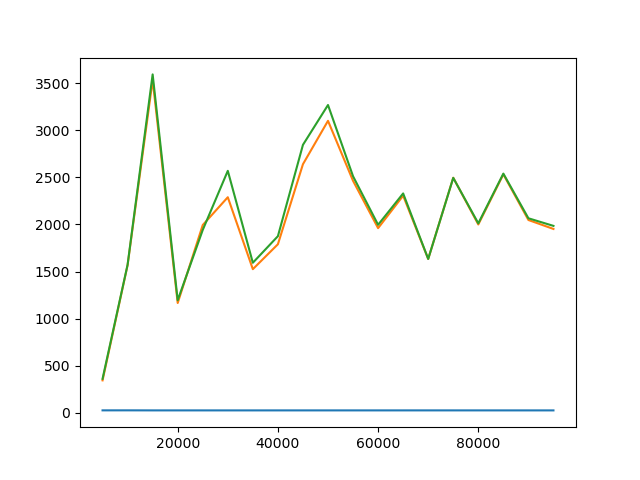

In [ ]:
figure()
plot(stop_times, snr_auto_w_int)
plot(stop_times, snr_cross_w_int)
plot(stop_times, snr_cross_no_quant_w_int)

In [ ]:
#Here we are trying to solve for the G.  If in total power, autos, then P_on is just a G proxy.  SNR sets an overall error term, and integration doesn't help that much.
#if switching on and off, then can get a G from (Pon-Poff)/(Ton-Toff) ratios.  Toff might be zero.
#Subtracting powers, gain error here will be decreasing as sqrt(time) with a sqrt(2) out front.
#for sim here using Ton=1 Toff=0 for simplicity.  

In [ ]:
gains = np.arange(0.0005,0.5,0.0005)

In [ ]:
gain_cross = []
gain_cross_no_quant = []
gain_auto = []
stop_time = 1000
#prob should actually regenerate noise...
#but when thats included, the scaling just looks random almost.  Highly dependent on the actual correlation of the off noise
for gain in gains:
    signal = np.random.normal(0, 2**0, 100000) +1.0j*np.random.normal(0, 2**0, 100000)
    noise_term = np.random.normal(0, 2**0, 100000) +1.0j*np.random.normal(0, 2**0, 100000)
    noise_term_off = np.random.normal(0, 2**0, 100000) +1.0j*np.random.normal(0, 2**0, 100000)
    f_signal_on = gain*signal + noise_term  #this way to make quantization easier
    f_signal_off = noise_term_off
    #q_signal_on = quantizer(f_signal_on, nbits=8)
    #q_signal_off = quantizer(f_signal_off, nbits=8)
    #q_signal_on = f_signal_on
    #q_signal_off = f_signal_off
    auto_corr_on = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(f_signal_on[:stop_time])))
    auto_corr_off = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(f_signal_off[:stop_time])))
    #cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    #cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_on_no_quant = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_off_no_quant = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    gain_cross_no_quant1 = abs(cross_corr_on_no_quant[0]) - abs(cross_corr_off_no_quant[0])
    #gain_cross1 = abs(cross_corr_on[0]) - abs(cross_corr_off[0])
    gain_auto1 = abs(auto_corr_on[0]) - abs(auto_corr_off[0])
    #gain_cross.append(gain_cross1)
    gain_auto.append(gain_auto1)
    gain_cross_no_quant.append(gain_cross_no_quant1)
    print("gain {}, gain auto= {}, gain_cross_no_quant={}".format(gain, gain_auto1, gain_cross_no_quant1))

gain 0.0005, gain auto= -29.351032494238098, gain_cross_no_quant=95.59372575265297
gain 0.001, gain auto= -70.26970531582833, gain_cross_no_quant=41.88341210192324
gain 0.0015, gain auto= -44.97311660482683, gain_cross_no_quant=-22.03696225613821
gain 0.002, gain auto= -42.540670882116956, gain_cross_no_quant=45.450986665123935
gain 0.0025, gain auto= -4.240879155921448, gain_cross_no_quant=-47.14743585976789
gain 0.003, gain auto= 60.97775310676593, gain_cross_no_quant=11.820094191560656
gain 0.0035, gain auto= -49.3441584215243, gain_cross_no_quant=89.81049032705558
gain 0.004, gain auto= -142.1705584247918, gain_cross_no_quant=-10.684998559838984
gain 0.0045000000000000005, gain auto= 36.59483504838454, gain_cross_no_quant=-23.581387878413075
gain 0.005000000000000001, gain auto= 61.213704441429854, gain_cross_no_quant=7.114171429402518
gain 0.0055, gain auto= 185.12043049156296, gain_cross_no_quant=-38.03417087715525
gain 0.006, gain auto= 121.89748914080019, gain_cross_no_quant=70

gain 0.05, gain auto= 194.37342953960865, gain_cross_no_quant=116.42069729366077
gain 0.0505, gain auto= -109.76858569756132, gain_cross_no_quant=86.12683623332785
gain 0.051000000000000004, gain auto= 23.932032903813706, gain_cross_no_quant=35.1221984527136
gain 0.051500000000000004, gain auto= -69.88385547772259, gain_cross_no_quant=-1.9971863343319711
gain 0.052000000000000005, gain auto= 4.924411025937616, gain_cross_no_quant=49.685227574322255
gain 0.052500000000000005, gain auto= 53.20038835313926, gain_cross_no_quant=52.573073206327706
gain 0.053, gain auto= 171.31535152322385, gain_cross_no_quant=35.372621373650304
gain 0.0535, gain auto= 140.93356847951827, gain_cross_no_quant=51.099502969684806
gain 0.054, gain auto= -26.127055262172007, gain_cross_no_quant=34.198222094348836
gain 0.0545, gain auto= 24.002994036063, gain_cross_no_quant=17.934292528165628
gain 0.055, gain auto= 146.94936372072243, gain_cross_no_quant=154.48832869245533
gain 0.0555, gain auto= -132.075032975527

gain 0.105, gain auto= 54.13784221086826, gain_cross_no_quant=80.66557280528798
gain 0.1055, gain auto= 96.14957847493702, gain_cross_no_quant=167.50176989917784
gain 0.106, gain auto= 88.61443123453705, gain_cross_no_quant=91.96588474894924
gain 0.1065, gain auto= -6.95476023179026, gain_cross_no_quant=173.67373300004274
gain 0.107, gain auto= 119.41988231000641, gain_cross_no_quant=209.34360472523085
gain 0.1075, gain auto= 13.724734401695741, gain_cross_no_quant=108.59507979678166
gain 0.108, gain auto= 75.13208061702971, gain_cross_no_quant=217.74022951236432
gain 0.1085, gain auto= 125.25903627322896, gain_cross_no_quant=134.6104100817588
gain 0.109, gain auto= 71.80789222963972, gain_cross_no_quant=143.81595908432595
gain 0.1095, gain auto= -10.423170549063343, gain_cross_no_quant=138.66823188450542
gain 0.11, gain auto= 80.57964429179788, gain_cross_no_quant=198.74743025813586
gain 0.1105, gain auto= 178.72699884904182, gain_cross_no_quant=233.11163430492007
gain 0.111, gain aut

gain 0.161, gain auto= -0.6550474320849844, gain_cross_no_quant=207.72811659329656
gain 0.1615, gain auto= -10.640030141262741, gain_cross_no_quant=244.8480687669445
gain 0.162, gain auto= 160.41335735002485, gain_cross_no_quant=372.292432784032
gain 0.1625, gain auto= 144.40692645669492, gain_cross_no_quant=314.98955050273975
gain 0.163, gain auto= 37.31449898213236, gain_cross_no_quant=343.65918567147787
gain 0.1635, gain auto= -32.38436580081998, gain_cross_no_quant=281.7967340901634
gain 0.164, gain auto= -23.650279300143666, gain_cross_no_quant=249.62715427351924
gain 0.1645, gain auto= 62.84230186014747, gain_cross_no_quant=269.7917796436696
gain 0.165, gain auto= -47.07164633415141, gain_cross_no_quant=167.70499319376773
gain 0.1655, gain auto= 45.88725603499847, gain_cross_no_quant=344.30839639576493
gain 0.166, gain auto= -21.36360137148904, gain_cross_no_quant=320.8871108257346
gain 0.1665, gain auto= 281.77773860046887, gain_cross_no_quant=320.67677294125446
gain 0.167, gain

gain 0.21, gain auto= 53.33596598639042, gain_cross_no_quant=254.92609641449795
gain 0.2105, gain auto= 77.31271676049164, gain_cross_no_quant=477.8731440285215
gain 0.211, gain auto= 76.46434122513028, gain_cross_no_quant=281.1441427986391
gain 0.2115, gain auto= 143.65039729691352, gain_cross_no_quant=470.4884292235869
gain 0.212, gain auto= 191.20641683426516, gain_cross_no_quant=314.7638881265348
gain 0.2125, gain auto= 212.2953182519484, gain_cross_no_quant=396.9672163501624
gain 0.213, gain auto= 96.01098769025884, gain_cross_no_quant=405.77866033497185
gain 0.2135, gain auto= 161.82857492974426, gain_cross_no_quant=381.25856008322705
gain 0.214, gain auto= 93.67571841257495, gain_cross_no_quant=407.5718564684151
gain 0.2145, gain auto= 61.051201324960175, gain_cross_no_quant=361.4950195614365
gain 0.215, gain auto= 172.596222426165, gain_cross_no_quant=468.1625328311326
gain 0.2155, gain auto= 142.9338218423718, gain_cross_no_quant=439.9518283378907
gain 0.216, gain auto= -55.35

gain 0.2675, gain auto= 145.37013548219875, gain_cross_no_quant=416.6688279324447
gain 0.268, gain auto= 189.94336283235498, gain_cross_no_quant=359.2939778034859
gain 0.2685, gain auto= -15.01645563426382, gain_cross_no_quant=473.6812147773039
gain 0.269, gain auto= 115.85096266749179, gain_cross_no_quant=447.05123662304374
gain 0.2695, gain auto= 203.31415711032741, gain_cross_no_quant=480.31832009683967
gain 0.27, gain auto= 165.5256500942519, gain_cross_no_quant=556.0191304872512
gain 0.2705, gain auto= 227.33348163708615, gain_cross_no_quant=459.9454055241607
gain 0.271, gain auto= 14.973307513573673, gain_cross_no_quant=478.29355485304035
gain 0.2715, gain auto= 196.6279287610655, gain_cross_no_quant=482.508166039516
gain 0.272, gain auto= 113.61915445327327, gain_cross_no_quant=451.56037325472573
gain 0.2725, gain auto= 125.15861305030057, gain_cross_no_quant=432.94426506539065
gain 0.273, gain auto= 91.09270167641398, gain_cross_no_quant=455.88200026736763
gain 0.2735, gain aut

gain 0.3255, gain auto= 326.3830271228924, gain_cross_no_quant=571.8053590561238
gain 0.326, gain auto= 261.0193011711124, gain_cross_no_quant=634.3098426972881
gain 0.3265, gain auto= 149.08138923492584, gain_cross_no_quant=561.0009941586235
gain 0.327, gain auto= 187.37991751872892, gain_cross_no_quant=581.0995915199765
gain 0.3275, gain auto= 104.10916965318893, gain_cross_no_quant=631.9937665216761
gain 0.328, gain auto= 161.78286687179252, gain_cross_no_quant=555.5546265545995
gain 0.3285, gain auto= 272.8022416865183, gain_cross_no_quant=575.586303225844
gain 0.329, gain auto= 380.33344017993886, gain_cross_no_quant=470.4585433083122
gain 0.3295, gain auto= 182.75802461332023, gain_cross_no_quant=618.8980096158089
gain 0.33, gain auto= 319.2736114137026, gain_cross_no_quant=614.2698416218826
gain 0.3305, gain auto= 287.7513519070842, gain_cross_no_quant=670.634165942188
gain 0.331, gain auto= 56.17800273147395, gain_cross_no_quant=631.3646973044436
gain 0.3315, gain auto= 265.343

gain 0.384, gain auto= 372.40725174433396, gain_cross_no_quant=699.9469635449238
gain 0.3845, gain auto= 15.336013614493822, gain_cross_no_quant=612.1771932470818
gain 0.385, gain auto= 333.6068977289274, gain_cross_no_quant=754.6149947128993
gain 0.3855, gain auto= 105.55065416680054, gain_cross_no_quant=648.5830749579984
gain 0.386, gain auto= 166.33968343556694, gain_cross_no_quant=667.7925540320637
gain 0.3865, gain auto= 313.2455404504292, gain_cross_no_quant=654.7239001801579
gain 0.387, gain auto= 421.24142444815357, gain_cross_no_quant=692.0630444436432
gain 0.3875, gain auto= 236.98272780213188, gain_cross_no_quant=720.6507709102308
gain 0.388, gain auto= 335.5381163658617, gain_cross_no_quant=635.4530040007021
gain 0.3885, gain auto= 406.82951952115513, gain_cross_no_quant=724.2817489149106
gain 0.389, gain auto= 284.00986774049693, gain_cross_no_quant=703.948010278093
gain 0.3895, gain auto= 259.248026460391, gain_cross_no_quant=787.1359990060994
gain 0.39, gain auto= 423.61

gain 0.434, gain auto= 279.51365739791436, gain_cross_no_quant=638.5287121656488
gain 0.4345, gain auto= 383.8146981257905, gain_cross_no_quant=788.251353614297
gain 0.435, gain auto= 407.8520232107271, gain_cross_no_quant=800.2163110545288
gain 0.4355, gain auto= 354.2784840919155, gain_cross_no_quant=757.910199926601
gain 0.436, gain auto= 287.60367608374736, gain_cross_no_quant=760.7237075046975
gain 0.4365, gain auto= 492.13776584859966, gain_cross_no_quant=716.2849029816214
gain 0.437, gain auto= 389.11694674578075, gain_cross_no_quant=702.4915574900339
gain 0.4375, gain auto= 286.04671402718577, gain_cross_no_quant=778.9500714125367
gain 0.438, gain auto= 427.7879847660231, gain_cross_no_quant=716.9136730331152
gain 0.4385, gain auto= 172.73104806166702, gain_cross_no_quant=743.7611779082085
gain 0.439, gain auto= 505.68123173153253, gain_cross_no_quant=935.7479037350181
gain 0.4395, gain auto= 440.9094372408549, gain_cross_no_quant=899.5512577395464
gain 0.44, gain auto= 232.703

gain 0.4835, gain auto= 646.3313040966664, gain_cross_no_quant=996.214589059941
gain 0.484, gain auto= 560.8851982065778, gain_cross_no_quant=925.6506684738163
gain 0.4845, gain auto= 379.4743521800831, gain_cross_no_quant=878.6076915403675
gain 0.485, gain auto= 454.91700230096126, gain_cross_no_quant=880.397556096705
gain 0.4855, gain auto= 274.25028566396395, gain_cross_no_quant=880.5023439777408
gain 0.486, gain auto= 631.9536913832649, gain_cross_no_quant=1018.6569155814933
gain 0.4865, gain auto= 511.6048354922475, gain_cross_no_quant=875.465506451421
gain 0.487, gain auto= 285.03727365953364, gain_cross_no_quant=873.580384300801
gain 0.4875, gain auto= 561.2409255406887, gain_cross_no_quant=921.5676724368719
gain 0.488, gain auto= 452.23749585928476, gain_cross_no_quant=896.2524319222539
gain 0.4885, gain auto= 569.660807170872, gain_cross_no_quant=1054.986500862461
gain 0.489, gain auto= 595.0458016312741, gain_cross_no_quant=929.6565676109136
gain 0.4895, gain auto= 571.504628

In [ ]:
gain_auto =np.array(gain_auto)
gain_cross_no_quant = np.array(gain_cross_no_quant)

<IPython.core.display.Javascript object>


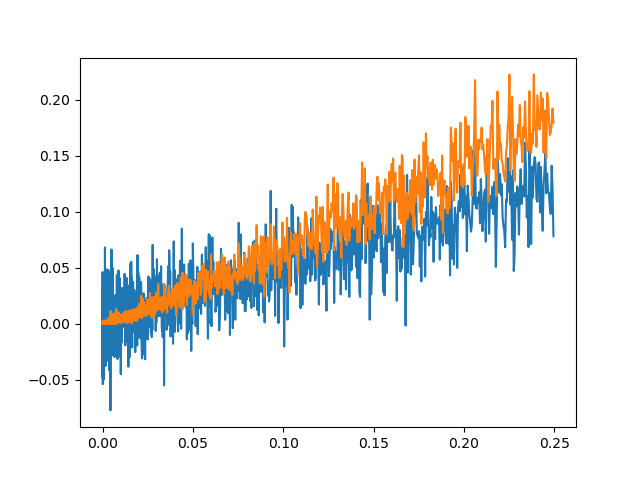

In [ ]:
figure()
plot(gains*gains, gain_auto/4e3)
plot(gains*gains, gain_cross_no_quant*gain_cross_no_quant/5e6)

In [ ]:
gain_cross = []
gain_cross_no_quant = []
gain_auto = []
stop_time = 4096
#prob should actually regenerate noise...
#but when thats included, the scaling just looks random almost.  Highly dependent on the actual correlation of the off noise
for gain in gains:
    signal = np.random.normal(0, 2**0, 100000) +1.0j*np.random.normal(0, 2**0, 100000)
    noise_term = np.random.normal(0, 2**0, 100000) +1.0j*np.random.normal(0, 2**0, 100000)
    noise_term_off = np.random.normal(0, 2**0, 100000) +1.0j*np.random.normal(0, 2**0, 100000)
    f_signal_on = gain*signal + noise_term  #this way to make quantization easier
    f_signal_off = noise_term_off
    #q_signal_on = quantizer(f_signal_on, nbits=8)
    #q_signal_off = quantizer(f_signal_off, nbits=8)
    #q_signal_on = f_signal_on
    #q_signal_off = f_signal_off
    auto_corr_on = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(f_signal_on[:stop_time])))
    auto_corr_off = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(f_signal_off[:stop_time])))
    #cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    #cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_on_no_quant = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_off_no_quant = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    gain_cross_no_quant1 = abs(cross_corr_on_no_quant[0]) - abs(cross_corr_off_no_quant[0])
    #gain_cross1 = abs(cross_corr_on[0]) - abs(cross_corr_off[0])
    gain_auto1 = abs(auto_corr_on[0]) - abs(auto_corr_off[0])
    #gain_cross.append(gain_cross1)
    gain_auto.append(gain_auto1)
    gain_cross_no_quant.append(gain_cross_no_quant1)
    print("gain {}, gain auto= {}, gain_cross_no_quant={}".format(gain, gain_auto1, gain_cross_no_quant1))

gain 0.0005, gain auto= -374.35657854206147, gain_cross_no_quant=24.948457825532394
gain 0.001, gain auto= -133.94270529449022, gain_cross_no_quant=46.87884502303466
gain 0.0015, gain auto= -184.35412691109832, gain_cross_no_quant=-26.492353274923033
gain 0.002, gain auto= -80.13101842743345, gain_cross_no_quant=63.967030353951586
gain 0.0025, gain auto= 11.958888573793047, gain_cross_no_quant=-53.7938492294375
gain 0.003, gain auto= -77.03425908091776, gain_cross_no_quant=-23.911958159988984
gain 0.0035, gain auto= 87.72727886218127, gain_cross_no_quant=-35.92781137635418
gain 0.004, gain auto= 90.99553598292732, gain_cross_no_quant=17.81542612097988
gain 0.0045000000000000005, gain auto= -189.1399951657222, gain_cross_no_quant=3.3441088213117496
gain 0.005000000000000001, gain auto= -210.54627393882947, gain_cross_no_quant=-170.3656732627781
gain 0.0055, gain auto= 5.500729500332454, gain_cross_no_quant=10.410264614750645
gain 0.006, gain auto= 316.288556527883, gain_cross_no_quant=2

gain 0.0565, gain auto= 245.52439722545023, gain_cross_no_quant=330.5739537211812
gain 0.057, gain auto= 225.14815741740858, gain_cross_no_quant=596.8820807986443
gain 0.0575, gain auto= 241.27499294129393, gain_cross_no_quant=362.26676173770187
gain 0.058, gain auto= -105.3706064424141, gain_cross_no_quant=226.34867829588697
gain 0.0585, gain auto= 240.12441334408504, gain_cross_no_quant=377.6947030348545
gain 0.059000000000000004, gain auto= 120.84275016679021, gain_cross_no_quant=300.3661353424364
gain 0.059500000000000004, gain auto= 163.10954145231517, gain_cross_no_quant=404.4509026545052
gain 0.060000000000000005, gain auto= 206.3846837264864, gain_cross_no_quant=396.8931123808661
gain 0.0605, gain auto= -44.89003645572029, gain_cross_no_quant=317.340572546471
gain 0.061, gain auto= -10.98933826927896, gain_cross_no_quant=372.08494441477404
gain 0.0615, gain auto= -217.48006159395936, gain_cross_no_quant=461.4431431692566
gain 0.062, gain auto= -62.114371487452445, gain_cross_no

gain 0.109, gain auto= 388.01535317980415, gain_cross_no_quant=922.8462447297235
gain 0.1095, gain auto= 131.85231131830733, gain_cross_no_quant=788.1845045663068
gain 0.11, gain auto= 155.70709979659296, gain_cross_no_quant=858.9482286310366
gain 0.1105, gain auto= 89.59808588022133, gain_cross_no_quant=923.6927800733803
gain 0.111, gain auto= 646.0916677720043, gain_cross_no_quant=739.9515578107695
gain 0.1115, gain auto= -183.6148120255648, gain_cross_no_quant=659.7808464791667
gain 0.112, gain auto= 123.70635748140194, gain_cross_no_quant=967.188998963194
gain 0.1125, gain auto= -112.4578202584944, gain_cross_no_quant=843.6036349827856
gain 0.113, gain auto= 317.2654224281014, gain_cross_no_quant=949.7925777130573
gain 0.1135, gain auto= 334.27228196936267, gain_cross_no_quant=780.874451299337
gain 0.114, gain auto= 475.84472491988345, gain_cross_no_quant=774.6036958267205
gain 0.1145, gain auto= 144.94941847002337, gain_cross_no_quant=797.7415241240311
gain 0.115, gain auto= -259.

gain 0.1645, gain auto= 317.8251677033222, gain_cross_no_quant=1200.138742283268
gain 0.165, gain auto= 71.96386820257794, gain_cross_no_quant=1127.005473286908
gain 0.1655, gain auto= 324.1471066744707, gain_cross_no_quant=1202.6229757306292
gain 0.166, gain auto= 259.02509140938037, gain_cross_no_quant=1321.3202375635412
gain 0.1665, gain auto= 236.3862411739192, gain_cross_no_quant=1258.5498298169132
gain 0.167, gain auto= 197.30180099971585, gain_cross_no_quant=1087.7889150426972
gain 0.1675, gain auto= 3.047553696171235, gain_cross_no_quant=1223.3514705023586
gain 0.168, gain auto= 302.18479403498714, gain_cross_no_quant=1280.279935602835
gain 0.1685, gain auto= 294.7129398552179, gain_cross_no_quant=1346.5964291368566
gain 0.169, gain auto= 416.1154672146149, gain_cross_no_quant=1133.635813473799
gain 0.1695, gain auto= 99.05861659800303, gain_cross_no_quant=1227.4444241099502
gain 0.17, gain auto= -111.17588349701691, gain_cross_no_quant=1181.797606030855
gain 0.1705, gain auto=

gain 0.2195, gain auto= 455.091999844597, gain_cross_no_quant=1624.4067372192849
gain 0.22, gain auto= 301.4249861903281, gain_cross_no_quant=1826.1047930394739
gain 0.2205, gain auto= 447.8120060808578, gain_cross_no_quant=1801.8650341885175
gain 0.221, gain auto= 81.99026715597756, gain_cross_no_quant=1659.2482676869179
gain 0.2215, gain auto= 442.1266604273742, gain_cross_no_quant=1705.7767916791895
gain 0.222, gain auto= 404.0246837080831, gain_cross_no_quant=1618.6218125802816
gain 0.2225, gain auto= 272.06677114128615, gain_cross_no_quant=1734.1298398231074
gain 0.223, gain auto= 393.2720444935985, gain_cross_no_quant=1605.588084357672
gain 0.2235, gain auto= 230.2199437587551, gain_cross_no_quant=1691.680012365504
gain 0.224, gain auto= 541.059033478391, gain_cross_no_quant=1901.180082765355
gain 0.2245, gain auto= 537.3479033561971, gain_cross_no_quant=1700.2603654852496
gain 0.225, gain auto= 38.771813783447215, gain_cross_no_quant=1436.7640148053813
gain 0.2255, gain auto= 10

gain 0.275, gain auto= 678.2719768229144, gain_cross_no_quant=2348.3150378497135
gain 0.2755, gain auto= 496.27954460833644, gain_cross_no_quant=2201.0735383266724
gain 0.276, gain auto= 701.0309218863003, gain_cross_no_quant=2097.7045910638203
gain 0.2765, gain auto= 562.6499763069969, gain_cross_no_quant=1860.0746879610795
gain 0.277, gain auto= 759.9549298594411, gain_cross_no_quant=2245.482859597909
gain 0.2775, gain auto= 346.3036984033097, gain_cross_no_quant=2150.6321070101853
gain 0.278, gain auto= 423.4174678682266, gain_cross_no_quant=2258.214581547997
gain 0.2785, gain auto= 677.4200916252239, gain_cross_no_quant=2068.0268515004122
gain 0.279, gain auto= 685.3313023586588, gain_cross_no_quant=2148.7419107715978
gain 0.2795, gain auto= 1086.94478230625, gain_cross_no_quant=2415.6165732398767
gain 0.28, gain auto= 557.3706194277529, gain_cross_no_quant=2250.3114257956986
gain 0.2805, gain auto= 682.0574299204654, gain_cross_no_quant=2076.1304876744375
gain 0.281, gain auto= 62

gain 0.331, gain auto= 889.6474064660015, gain_cross_no_quant=2620.332012484535
gain 0.3315, gain auto= 1092.5382021940477, gain_cross_no_quant=2724.2867901463087
gain 0.332, gain auto= 1263.3244416292673, gain_cross_no_quant=2811.6669980596985
gain 0.3325, gain auto= 916.7051663131242, gain_cross_no_quant=2633.419937564752
gain 0.333, gain auto= 925.2478002609332, gain_cross_no_quant=2420.833295607171
gain 0.3335, gain auto= 840.3514188074041, gain_cross_no_quant=2490.884938408286
gain 0.334, gain auto= 1193.843828651361, gain_cross_no_quant=2517.407180234219
gain 0.3345, gain auto= 801.940919319155, gain_cross_no_quant=2672.989896228615
gain 0.335, gain auto= 1067.125836236185, gain_cross_no_quant=2542.0740651919887
gain 0.3355, gain auto= 861.8962512149137, gain_cross_no_quant=2672.3135953330507
gain 0.336, gain auto= 567.892463397051, gain_cross_no_quant=2522.2257897147756
gain 0.3365, gain auto= 968.1481859071318, gain_cross_no_quant=2648.598244947065
gain 0.337, gain auto= 938.05

gain 0.387, gain auto= 1163.4571186670055, gain_cross_no_quant=3086.987766820368
gain 0.3875, gain auto= 1392.6417771394135, gain_cross_no_quant=3036.9846621086713
gain 0.388, gain auto= 1286.5045035000467, gain_cross_no_quant=3135.6171698939447
gain 0.3885, gain auto= 1404.4274767424931, gain_cross_no_quant=3082.439773428871
gain 0.389, gain auto= 838.5345077075726, gain_cross_no_quant=3042.911809993728
gain 0.3895, gain auto= 948.4191683893023, gain_cross_no_quant=2995.276643426354
gain 0.39, gain auto= 873.8762598883477, gain_cross_no_quant=3147.065712651645
gain 0.3905, gain auto= 1624.7310394326832, gain_cross_no_quant=3068.893040889876
gain 0.391, gain auto= 1713.7036497119052, gain_cross_no_quant=3406.9417285374525
gain 0.3915, gain auto= 765.874193499867, gain_cross_no_quant=2866.403494047418
gain 0.392, gain auto= 1408.3684676464636, gain_cross_no_quant=3271.1390532561177
gain 0.3925, gain auto= 1652.2965128399283, gain_cross_no_quant=3113.150306670776
gain 0.393, gain auto= 8

gain 0.443, gain auto= 1775.6829434494284, gain_cross_no_quant=3520.9748874562683
gain 0.4435, gain auto= 1522.6646388350346, gain_cross_no_quant=3794.297673470999
gain 0.444, gain auto= 1777.082991751533, gain_cross_no_quant=3573.3137110360926
gain 0.4445, gain auto= 1546.6371286286303, gain_cross_no_quant=3597.6155227989775
gain 0.445, gain auto= 1466.6951356411228, gain_cross_no_quant=3448.037255110017
gain 0.4455, gain auto= 1508.0675669760167, gain_cross_no_quant=3550.6782624229795
gain 0.446, gain auto= 1404.8537713505702, gain_cross_no_quant=3482.3801181878152
gain 0.4465, gain auto= 1574.0075203600918, gain_cross_no_quant=3636.9928577301594
gain 0.447, gain auto= 1619.4055547776152, gain_cross_no_quant=3550.9220856983757
gain 0.4475, gain auto= 1635.6515571749642, gain_cross_no_quant=3486.7403417750006
gain 0.448, gain auto= 1477.9534975874703, gain_cross_no_quant=3399.978744473869
gain 0.4485, gain auto= 1621.7268846202742, gain_cross_no_quant=3542.3572944260172
gain 0.449, ga

gain 0.499, gain auto= 1836.1222128630725, gain_cross_no_quant=4070.3331385206343
gain 0.4995, gain auto= 2175.3424678743577, gain_cross_no_quant=3981.3217380701


In [ ]:
gain_auto =np.array(gain_auto)
gain_cross_no_quant = np.array(gain_cross_no_quant)

<IPython.core.display.Javascript object>


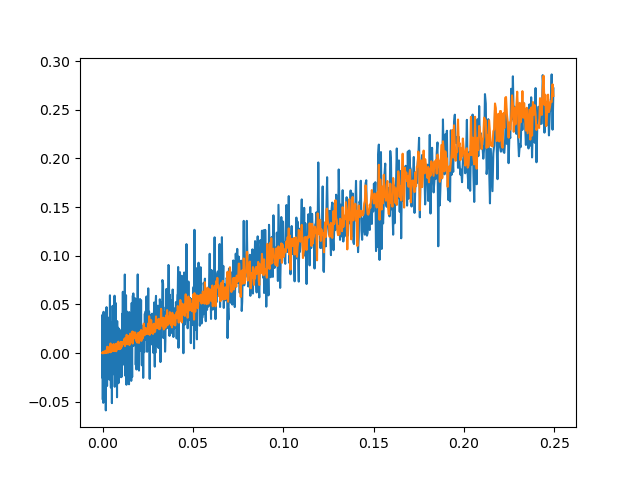

In [ ]:
figure()
plot(gains*gains, gain_auto/8e3)
plot(gains*gains, gain_cross_no_quant*gain_cross_no_quant/6e7)

In [ ]:
gain_cross = []
gain_cross_no_quant = []
gain_auto = []
stop_time = 100000
#prob should actually regenerate noise...
#but when thats included, the scaling just looks random almost.  Highly dependent on the actual correlation of the off noise
for gain in gains:
    signal = np.random.normal(0, 1.0/np.sqrt(2), 100000) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), 100000)
    noise_term = np.random.normal(0, 1.0/np.sqrt(2), 100000) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), 100000)
    noise_term_off = np.random.normal(0, 1.0/np.sqrt(2), 100000) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), 100000)
    f_signal_on = gain*signal + noise_term  #this way to make quantization easier
    f_signal_off = noise_term_off
    #q_signal_on = quantizer(f_signal_on, nbits=8)
    #q_signal_off = quantizer(f_signal_off, nbits=8)
    #q_signal_on = f_signal_on
    #q_signal_off = f_signal_off
    auto_corr_on = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(f_signal_on[:stop_time])))
    auto_corr_off = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(f_signal_off[:stop_time])))
    #cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    #cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_on_no_quant = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    cross_corr_off_no_quant = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
    gain_cross_no_quant1 = abs(cross_corr_on_no_quant[0]) - abs(cross_corr_off_no_quant[0])
    #gain_cross1 = abs(cross_corr_on[0]) - abs(cross_corr_off[0])
    gain_auto1 = abs(auto_corr_on[0]) - abs(auto_corr_off[0])
    #gain_cross.append(gain_cross1)
    gain_auto.append(gain_auto1)
    gain_cross_no_quant.append(gain_cross_no_quant1)
    print("gain {}, gain auto= {}, gain_cross_no_quant={}".format(gain, gain_auto1, gain_cross_no_quant1))

gain 0.0005, gain auto= 1238.9000168582425, gain_cross_no_quant=301.9708273108388
gain 0.001, gain auto= -6.008821947572869, gain_cross_no_quant=139.8251318232604
gain 0.0015, gain auto= -215.62904793895723, gain_cross_no_quant=29.05916365171862
gain 0.002, gain auto= 178.74309141044796, gain_cross_no_quant=-137.40400479595445
gain 0.0025, gain auto= -448.74426249704266, gain_cross_no_quant=78.0241803558091
gain 0.003, gain auto= -272.0330040490371, gain_cross_no_quant=8.896820012821422
gain 0.0035, gain auto= -1045.4051301597356, gain_cross_no_quant=138.95561610446566
gain 0.004, gain auto= 399.2061454197683, gain_cross_no_quant=-491.30309259055196
gain 0.0045000000000000005, gain auto= -193.9120589843369, gain_cross_no_quant=185.60779862376882
gain 0.005000000000000001, gain auto= -628.7270305247657, gain_cross_no_quant=60.233421578594914
gain 0.0055, gain auto= 334.74655112152686, gain_cross_no_quant=605.4056213077812
gain 0.006, gain auto= -273.9001434904785, gain_cross_no_quant=49

gain 0.049, gain auto= 249.17775422321574, gain_cross_no_quant=4167.23914598184
gain 0.0495, gain auto= 246.2640125140315, gain_cross_no_quant=4660.346281657034
gain 0.05, gain auto= 598.08930416152, gain_cross_no_quant=4885.005291289296
gain 0.0505, gain auto= -112.51384960238647, gain_cross_no_quant=4715.801956215067
gain 0.051000000000000004, gain auto= 831.0430266660405, gain_cross_no_quant=4881.509927816701
gain 0.051500000000000004, gain auto= 59.01897528555128, gain_cross_no_quant=5121.700747149825
gain 0.052000000000000005, gain auto= 501.8781399196596, gain_cross_no_quant=5240.748936910967
gain 0.052500000000000005, gain auto= 968.260788614105, gain_cross_no_quant=5080.816294529544
gain 0.053, gain auto= -39.961616710264934, gain_cross_no_quant=5380.933542328366
gain 0.0535, gain auto= 278.6041465401504, gain_cross_no_quant=4986.0027815771755
gain 0.054, gain auto= 526.9027111665782, gain_cross_no_quant=5177.360861658172
gain 0.0545, gain auto= -332.91451214689005, gain_cross_

gain 0.1, gain auto= 912.6103174750315, gain_cross_no_quant=9456.199314758758
gain 0.1005, gain auto= 751.7223186232441, gain_cross_no_quant=10069.04371200744
gain 0.101, gain auto= 888.6160639229201, gain_cross_no_quant=9780.914521947458
gain 0.1015, gain auto= 1065.928408924825, gain_cross_no_quant=9972.740979304923
gain 0.10200000000000001, gain auto= 1259.5487455803377, gain_cross_no_quant=10181.264054765228
gain 0.10250000000000001, gain auto= 1072.9291118828987, gain_cross_no_quant=10262.965811765835
gain 0.10300000000000001, gain auto= 543.8914291327092, gain_cross_no_quant=9889.815307892271
gain 0.10350000000000001, gain auto= 208.4953935854428, gain_cross_no_quant=9937.0896391074
gain 0.10400000000000001, gain auto= 989.6189791741926, gain_cross_no_quant=9945.926968608721
gain 0.10450000000000001, gain auto= 1396.1870044107927, gain_cross_no_quant=10429.280519914795
gain 0.105, gain auto= 1008.7656144080684, gain_cross_no_quant=9841.052527530403
gain 0.1055, gain auto= 1514.04

gain 0.15, gain auto= 2060.599580278591, gain_cross_no_quant=14529.762262727014
gain 0.1505, gain auto= 1694.0707459568803, gain_cross_no_quant=14559.688649819313
gain 0.151, gain auto= 2184.8548632787715, gain_cross_no_quant=14774.74495624655
gain 0.1515, gain auto= 2632.8176578509156, gain_cross_no_quant=15129.623950378786
gain 0.152, gain auto= 1612.9618741260492, gain_cross_no_quant=14821.292613421574
gain 0.1525, gain auto= 3009.748726367776, gain_cross_no_quant=15084.187835349248
gain 0.153, gain auto= 2519.3955222367076, gain_cross_no_quant=15168.175241713652
gain 0.1535, gain auto= 1929.370316734421, gain_cross_no_quant=15071.311679484294
gain 0.154, gain auto= 3126.430194976958, gain_cross_no_quant=15211.171373271092
gain 0.1545, gain auto= 1890.2087190314924, gain_cross_no_quant=14855.780098348254
gain 0.155, gain auto= 2685.2158616965608, gain_cross_no_quant=14975.598052261746
gain 0.1555, gain auto= 3024.4767249423167, gain_cross_no_quant=15706.127104177167
gain 0.156, gain

gain 0.2015, gain auto= 4276.434731414061, gain_cross_no_quant=20255.724467795855
gain 0.202, gain auto= 4328.556458270032, gain_cross_no_quant=19538.30284472867
gain 0.2025, gain auto= 4136.116560286158, gain_cross_no_quant=19921.128298327483
gain 0.203, gain auto= 4131.794065186157, gain_cross_no_quant=20079.57373221184
gain 0.20350000000000001, gain auto= 3716.5566458119574, gain_cross_no_quant=19915.92021458436
gain 0.20400000000000001, gain auto= 4232.871012642281, gain_cross_no_quant=20022.95020784869
gain 0.20450000000000002, gain auto= 4504.732711655684, gain_cross_no_quant=20296.50716409954
gain 0.20500000000000002, gain auto= 4300.101286581761, gain_cross_no_quant=20293.632239541592
gain 0.20550000000000002, gain auto= 3977.047796378087, gain_cross_no_quant=20159.442323780753
gain 0.20600000000000002, gain auto= 5002.127122637394, gain_cross_no_quant=20512.130053152243
gain 0.20650000000000002, gain auto= 3731.2794079260348, gain_cross_no_quant=20455.243080204935
gain 0.20700

gain 0.2545, gain auto= 6546.855244557344, gain_cross_no_quant=25490.07454874303
gain 0.255, gain auto= 6795.927680545559, gain_cross_no_quant=25350.00434543749
gain 0.2555, gain auto= 6874.174304132379, gain_cross_no_quant=25609.13687349661
gain 0.256, gain auto= 5776.859398733257, gain_cross_no_quant=25502.79218824804
gain 0.2565, gain auto= 6640.35100252385, gain_cross_no_quant=25199.680517825902
gain 0.257, gain auto= 6868.437257721365, gain_cross_no_quant=25616.14076847181
gain 0.2575, gain auto= 6264.1452166166855, gain_cross_no_quant=25206.37688745664
gain 0.258, gain auto= 7073.180567698117, gain_cross_no_quant=25156.722774432536
gain 0.2585, gain auto= 6471.02677877956, gain_cross_no_quant=25320.366392087024
gain 0.259, gain auto= 6703.924022154999, gain_cross_no_quant=25444.668276820896
gain 0.2595, gain auto= 5804.260423274725, gain_cross_no_quant=25206.970197797415
gain 0.26, gain auto= 7160.736629435254, gain_cross_no_quant=25519.077722754555
gain 0.2605, gain auto= 6074.3

gain 0.306, gain auto= 8839.128817621255, gain_cross_no_quant=30708.186137308032
gain 0.3065, gain auto= 10149.125468165657, gain_cross_no_quant=30476.697689215034
gain 0.307, gain auto= 8094.7105493260315, gain_cross_no_quant=30348.267857072377
gain 0.3075, gain auto= 9752.2597236593, gain_cross_no_quant=30519.058383918662
gain 0.308, gain auto= 8957.382501056447, gain_cross_no_quant=30521.933230886432
gain 0.3085, gain auto= 9537.994114159403, gain_cross_no_quant=30955.91910998569
gain 0.309, gain auto= 9089.234252211492, gain_cross_no_quant=30127.252305857728
gain 0.3095, gain auto= 9804.653447401186, gain_cross_no_quant=30949.32851901531
gain 0.31, gain auto= 9001.453040431341, gain_cross_no_quant=30045.681150263496
gain 0.3105, gain auto= 10283.169087160873, gain_cross_no_quant=30513.14860237422
gain 0.311, gain auto= 8730.283750847055, gain_cross_no_quant=30519.74040266878
gain 0.3115, gain auto= 9867.06616067623, gain_cross_no_quant=30874.460953769725
gain 0.312, gain auto= 1124

gain 0.3585, gain auto= 12156.344038131152, gain_cross_no_quant=35235.560736370404
gain 0.359, gain auto= 12830.112030997276, gain_cross_no_quant=35568.65413492857
gain 0.3595, gain auto= 12524.53067459377, gain_cross_no_quant=35769.96205974696
gain 0.36, gain auto= 11968.05170594537, gain_cross_no_quant=35495.21009563862
gain 0.3605, gain auto= 13108.26654347658, gain_cross_no_quant=36043.06784745519
gain 0.361, gain auto= 13159.493805848891, gain_cross_no_quant=35698.218594418046
gain 0.3615, gain auto= 12766.04921879356, gain_cross_no_quant=35360.10710373957
gain 0.362, gain auto= 13173.654677465063, gain_cross_no_quant=35581.43973863442
gain 0.3625, gain auto= 12702.408632631035, gain_cross_no_quant=35831.89746448074
gain 0.363, gain auto= 13079.586254676178, gain_cross_no_quant=36086.88917042782
gain 0.3635, gain auto= 13335.920897193355, gain_cross_no_quant=36436.5930555801
gain 0.364, gain auto= 12941.961753134048, gain_cross_no_quant=36111.79191967132
gain 0.3645, gain auto= 12

gain 0.41200000000000003, gain auto= 16838.511788301665, gain_cross_no_quant=41500.40658753978
gain 0.41250000000000003, gain auto= 17667.061218897536, gain_cross_no_quant=41184.622094556216
gain 0.41300000000000003, gain auto= 16093.981955742245, gain_cross_no_quant=41179.781033862
gain 0.41350000000000003, gain auto= 18360.910362392155, gain_cross_no_quant=41307.254493866014
gain 0.41400000000000003, gain auto= 17448.892303158966, gain_cross_no_quant=41248.83690610219
gain 0.41450000000000004, gain auto= 17206.613404191332, gain_cross_no_quant=41370.59562278817
gain 0.41500000000000004, gain auto= 18062.132852529016, gain_cross_no_quant=41653.73880563421
gain 0.41550000000000004, gain auto= 17688.73618543864, gain_cross_no_quant=41258.40991245349
gain 0.41600000000000004, gain auto= 17129.12566284927, gain_cross_no_quant=41041.09674982066
gain 0.41650000000000004, gain auto= 17041.251365480755, gain_cross_no_quant=41089.002861876186
gain 0.417, gain auto= 17246.717558161617, gain_cro

gain 0.466, gain auto= 22099.288724987215, gain_cross_no_quant=46353.497004693345
gain 0.4665, gain auto= 21993.86852473198, gain_cross_no_quant=46393.68606944717
gain 0.467, gain auto= 21917.45376265979, gain_cross_no_quant=46111.505805970824
gain 0.4675, gain auto= 22166.115715581065, gain_cross_no_quant=46835.80906392792
gain 0.468, gain auto= 21656.580705116517, gain_cross_no_quant=46083.06623712988
gain 0.4685, gain auto= 21841.482906976264, gain_cross_no_quant=46653.4341317624
gain 0.46900000000000003, gain auto= 22175.925031824343, gain_cross_no_quant=46888.78208227066
gain 0.46950000000000003, gain auto= 20943.873745842255, gain_cross_no_quant=46393.820470714345
gain 0.47000000000000003, gain auto= 22605.84410920886, gain_cross_no_quant=46499.67823042443
gain 0.47050000000000003, gain auto= 22097.16975762935, gain_cross_no_quant=46601.07906346681
gain 0.47100000000000003, gain auto= 22022.409454458524, gain_cross_no_quant=46505.85606723383
gain 0.47150000000000003, gain auto= 2

In [ ]:
gain_auto =np.array(gain_auto)
gain_cross_no_quant = np.array(gain_cross_no_quant)

<IPython.core.display.Javascript object>


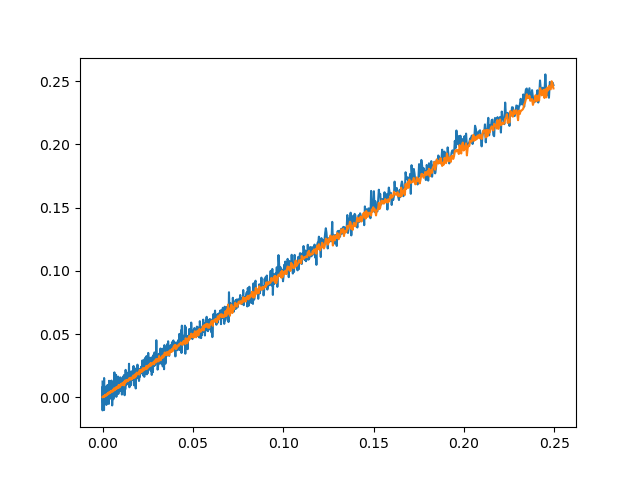

In [ ]:
figure()
plot(gains*gains, gain_auto/1e5)
plot(gains*gains, gain_cross_no_quant*gain_cross_no_quant/1e5/1e5)

<IPython.core.display.Javascript object>


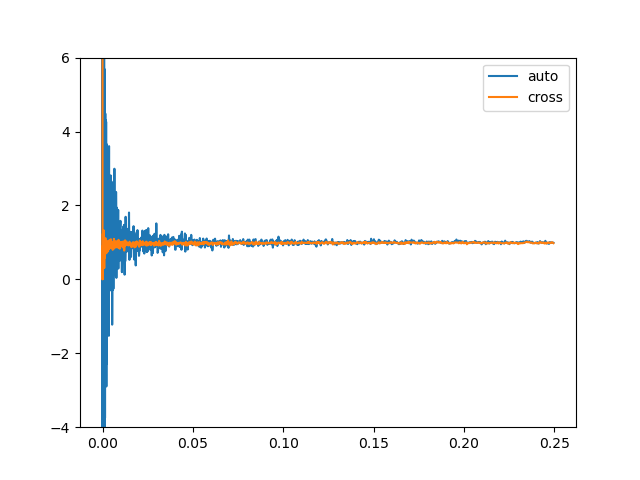

In [ ]:
figure()
plot(gains*gains, gain_auto/1e5/(gains*gains), label='auto')  
plot(gains*gains, gain_cross_no_quant*gain_cross_no_quant/1e10/(gains*gains), label="cross")  #4e10
ylim(-4,6)
legend()

<IPython.core.display.Javascript object>


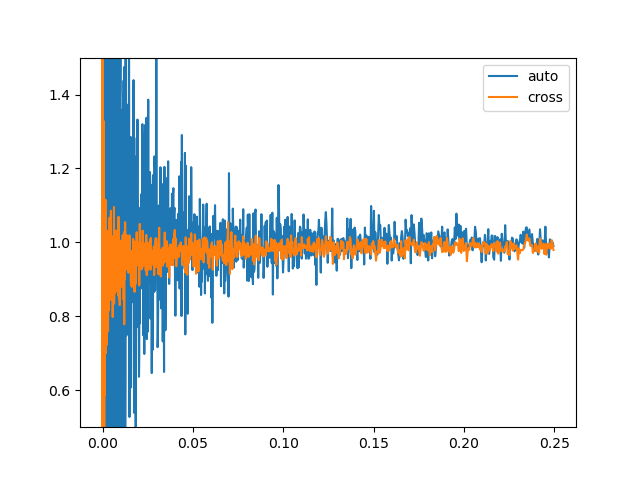

In [ ]:
figure()
plot(gains*gains, gain_auto/1e5/(gains*gains), label='auto')  
plot(gains*gains, gain_cross_no_quant*gain_cross_no_quant/1e10/(gains*gains), label="cross")  #4e10
ylim(0.5,1.5)
legend()

In [ ]:
gains = np.arange(0.05,1,0.05)
n_gains = len(gains)
repeats = 100
stop_time = 100000
gain_cross_no_quant = np.zeros((repeats,n_gains))
gain_auto = np.zeros((repeats,n_gains))


for i,gain in enumerate(gains):
    for j in np.arange(repeats):
        signal = np.random.normal(0, 1.0/np.sqrt(2), stop_time) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), stop_time)
        noise_term = np.random.normal(0, 1.0/np.sqrt(2), stop_time) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), stop_time)
        noise_term_off = np.random.normal(0, 1.0/np.sqrt(2), stop_time) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), stop_time)
        f_signal_on = gain*signal + noise_term  #this way to make quantization easier
        f_signal_off = noise_term_off
        #q_signal_on = quantizer(f_signal_on, nbits=8)
        #q_signal_off = quantizer(f_signal_off, nbits=8)
        #q_signal_on = f_signal_on
        #q_signal_off = f_signal_off
        auto_corr_on = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(f_signal_on[:stop_time])))
        auto_corr_off = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(f_signal_off[:stop_time])))
        #cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
        #cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
        cross_corr_on_no_quant = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
        cross_corr_off_no_quant = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
        gain_cross_no_quant1 = abs(cross_corr_on_no_quant[0]) - abs(cross_corr_off_no_quant[0])
        #gain_cross1 = abs(cross_corr_on[0]) - abs(cross_corr_off[0])
        gain_auto1 = abs(auto_corr_on[0]) - abs(auto_corr_off[0])
        #gain_cross.append(gain_cross1)
        gain_auto[j,i] = gain_auto1
        gain_cross_no_quant[j,i] = gain_cross_no_quant1
        print("gain {}, gain auto= {}, gain_cross_no_quant={}".format(gain, gain_auto1, gain_cross_no_quant1))

gain 0.05, gain auto= -38.754677258461015, gain_cross_no_quant=4914.720022135611
gain 0.05, gain auto= -132.9520515111799, gain_cross_no_quant=5211.992815780107
gain 0.05, gain auto= 0.9053161392366746, gain_cross_no_quant=4519.600837228616
gain 0.05, gain auto= 91.34333110596344, gain_cross_no_quant=4804.462177153209
gain 0.05, gain auto= -506.1578738128592, gain_cross_no_quant=5105.444020086611
gain 0.05, gain auto= 370.7934430556197, gain_cross_no_quant=4857.482375628291
gain 0.05, gain auto= 606.6380774612044, gain_cross_no_quant=4341.714424531328
gain 0.05, gain auto= -453.98826215264853, gain_cross_no_quant=4343.016255580727
gain 0.05, gain auto= 899.2946100982372, gain_cross_no_quant=5150.666721222223
gain 0.05, gain auto= 434.7891377918131, gain_cross_no_quant=4704.3476721706065
gain 0.05, gain auto= -17.863140320056118, gain_cross_no_quant=4748.7695492538705
gain 0.05, gain auto= 929.1625848596304, gain_cross_no_quant=4614.673628412098
gain 0.05, gain auto= 826.3706531744392, 

gain 0.1, gain auto= 1456.7843852117076, gain_cross_no_quant=9332.736149229593
gain 0.1, gain auto= 1281.6006719119323, gain_cross_no_quant=9482.740998887808
gain 0.1, gain auto= 1560.223421754723, gain_cross_no_quant=9398.23324956223
gain 0.1, gain auto= 1032.759141110655, gain_cross_no_quant=10088.042034879123
gain 0.1, gain auto= 1054.1975949017506, gain_cross_no_quant=10148.027160729975
gain 0.1, gain auto= 1391.456504668371, gain_cross_no_quant=9151.957250589712
gain 0.1, gain auto= 552.9231095463911, gain_cross_no_quant=9733.566542266455
gain 0.1, gain auto= 1250.6954181261535, gain_cross_no_quant=9766.060463585465
gain 0.1, gain auto= 1066.1231216512388, gain_cross_no_quant=9750.87658426994
gain 0.1, gain auto= 1080.5191984755802, gain_cross_no_quant=9395.850655707427
gain 0.1, gain auto= 448.81754850149446, gain_cross_no_quant=10096.68702691973
gain 0.1, gain auto= 811.8346022661863, gain_cross_no_quant=9801.284009521756
gain 0.1, gain auto= 913.0320862549706, gain_cross_no_qua

gain 0.15000000000000002, gain auto= 1486.6542170087341, gain_cross_no_quant=14140.068513074239
gain 0.15000000000000002, gain auto= 2181.749739052015, gain_cross_no_quant=14806.752216133928
gain 0.15000000000000002, gain auto= 1910.0899038798525, gain_cross_no_quant=14663.25251798897
gain 0.15000000000000002, gain auto= 2061.7703031072306, gain_cross_no_quant=13729.8903055946
gain 0.15000000000000002, gain auto= 1976.6527383468347, gain_cross_no_quant=14977.068389400889
gain 0.15000000000000002, gain auto= 2154.2834049839876, gain_cross_no_quant=14754.92148346998
gain 0.15000000000000002, gain auto= 2160.443641304635, gain_cross_no_quant=14227.525806930882
gain 0.15000000000000002, gain auto= 2453.5498966047453, gain_cross_no_quant=14522.775820150575
gain 0.15000000000000002, gain auto= 1845.4685475690494, gain_cross_no_quant=14944.77130139482
gain 0.15000000000000002, gain auto= 2515.8781523104117, gain_cross_no_quant=14462.35239434132
gain 0.15000000000000002, gain auto= 2421.601593

gain 0.2, gain auto= 3437.6086955141654, gain_cross_no_quant=19671.42330542586
gain 0.2, gain auto= 4253.328411538212, gain_cross_no_quant=19369.014987975366
gain 0.2, gain auto= 3665.7321733736026, gain_cross_no_quant=19993.742031666916
gain 0.2, gain auto= 4392.53705950336, gain_cross_no_quant=19271.691465150874
gain 0.2, gain auto= 3738.0328909964446, gain_cross_no_quant=20139.805885089685
gain 0.2, gain auto= 4854.286751855208, gain_cross_no_quant=19991.35384490141
gain 0.2, gain auto= 3554.9559503943747, gain_cross_no_quant=19626.27550122202
gain 0.2, gain auto= 4407.56184644287, gain_cross_no_quant=19764.772779897095
gain 0.2, gain auto= 3911.1222299790097, gain_cross_no_quant=19773.853626235683
gain 0.2, gain auto= 4029.7568661410187, gain_cross_no_quant=19675.978633628336
gain 0.2, gain auto= 3840.468233970052, gain_cross_no_quant=19712.59665443664
gain 0.2, gain auto= 4405.104726066071, gain_cross_no_quant=19565.555384286316
gain 0.2, gain auto= 4817.0324384981795, gain_cross_

gain 0.25, gain auto= 5972.127650882307, gain_cross_no_quant=24806.67903619223
gain 0.25, gain auto= 5945.228069993827, gain_cross_no_quant=24894.982078251473
gain 0.25, gain auto= 5672.40015505832, gain_cross_no_quant=24382.68854954676
gain 0.25, gain auto= 6537.638134243534, gain_cross_no_quant=24912.614270446596
gain 0.25, gain auto= 6167.006002047026, gain_cross_no_quant=24934.590946138942
gain 0.25, gain auto= 6723.15426395231, gain_cross_no_quant=24911.767980473618
gain 0.25, gain auto= 6193.060144238509, gain_cross_no_quant=24590.72444669691
gain 0.25, gain auto= 5955.112921792112, gain_cross_no_quant=24701.654783378846
gain 0.25, gain auto= 6919.13233193112, gain_cross_no_quant=24865.871843777422
gain 0.25, gain auto= 6203.138044929161, gain_cross_no_quant=24327.101076135194
gain 0.25, gain auto= 6330.987708498127, gain_cross_no_quant=24695.60920403174
gain 0.25, gain auto= 6703.874511691363, gain_cross_no_quant=24972.274403628202
gain 0.25, gain auto= 6009.476868313694, gain_c

gain 0.3, gain auto= 9046.091549672667, gain_cross_no_quant=30006.09140162554
gain 0.3, gain auto= 8033.319479513695, gain_cross_no_quant=29966.553481491133
gain 0.3, gain auto= 8999.687976308516, gain_cross_no_quant=29892.05288085246
gain 0.3, gain auto= 9010.283230786838, gain_cross_no_quant=29551.458018081285
gain 0.3, gain auto= 8884.235505663266, gain_cross_no_quant=29599.988084499208
gain 0.3, gain auto= 8093.701343812514, gain_cross_no_quant=29411.499980573484
gain 0.3, gain auto= 9108.702481768094, gain_cross_no_quant=29594.0395260684
gain 0.3, gain auto= 9214.46716962778, gain_cross_no_quant=29779.14974669558
gain 0.3, gain auto= 9901.43326894453, gain_cross_no_quant=29874.970729802746
gain 0.3, gain auto= 9359.57862848985, gain_cross_no_quant=29853.088264931666
gain 0.3, gain auto= 9183.11403825268, gain_cross_no_quant=29470.271906592272
gain 0.3, gain auto= 8838.480555284405, gain_cross_no_quant=29932.076443203136
gain 0.3, gain auto= 8898.204485254784, gain_cross_no_quant=2

gain 0.35000000000000003, gain auto= 12615.299405786398, gain_cross_no_quant=34910.72029469478
gain 0.35000000000000003, gain auto= 12002.649700601236, gain_cross_no_quant=34644.28210867983
gain 0.35000000000000003, gain auto= 12479.510850823965, gain_cross_no_quant=35081.938641493085
gain 0.35000000000000003, gain auto= 12424.603184534702, gain_cross_no_quant=35163.00343950732
gain 0.35000000000000003, gain auto= 12190.364285674048, gain_cross_no_quant=34743.34220809445
gain 0.35000000000000003, gain auto= 12325.811828648511, gain_cross_no_quant=34850.930419241864
gain 0.35000000000000003, gain auto= 12981.52122116099, gain_cross_no_quant=34812.66076434282
gain 0.35000000000000003, gain auto= 12681.493722483021, gain_cross_no_quant=34752.754035245394
gain 0.35000000000000003, gain auto= 11889.078171327084, gain_cross_no_quant=34603.23959216584
gain 0.35000000000000003, gain auto= 11768.42787585291, gain_cross_no_quant=34567.78417912193
gain 0.35000000000000003, gain auto= 12525.219019

gain 0.4, gain auto= 15511.526511294374, gain_cross_no_quant=39768.18901344241
gain 0.4, gain auto= 16602.742565538952, gain_cross_no_quant=39889.00573899343
gain 0.4, gain auto= 16522.155014721153, gain_cross_no_quant=39940.38592717826
gain 0.4, gain auto= 16140.458328298933, gain_cross_no_quant=39502.7663743527
gain 0.4, gain auto= 15938.235666891778, gain_cross_no_quant=39615.70119626526
gain 0.4, gain auto= 17522.97357946745, gain_cross_no_quant=40399.02922666655
gain 0.4, gain auto= 16516.96933629048, gain_cross_no_quant=40217.93453551719
gain 0.4, gain auto= 16119.580761404533, gain_cross_no_quant=39873.90132347683
gain 0.4, gain auto= 16127.238860045007, gain_cross_no_quant=39546.285408764656
gain 0.4, gain auto= 15983.142267086485, gain_cross_no_quant=40225.2956082723
gain 0.4, gain auto= 15412.460149694714, gain_cross_no_quant=39454.01836243401
gain 0.4, gain auto= 16845.091270603283, gain_cross_no_quant=39963.663673136536
gain 0.4, gain auto= 15393.35044175318, gain_cross_no_

gain 0.45, gain auto= 19738.168363521312, gain_cross_no_quant=44850.18316814513
gain 0.45, gain auto= 20785.474770217275, gain_cross_no_quant=44590.28640679439
gain 0.45, gain auto= 20178.386600959653, gain_cross_no_quant=44141.0267796395
gain 0.45, gain auto= 19626.26298147996, gain_cross_no_quant=44749.61471301183
gain 0.45, gain auto= 20501.857807745517, gain_cross_no_quant=45151.021522852796
gain 0.45, gain auto= 20448.479741012197, gain_cross_no_quant=44975.931388152385
gain 0.45, gain auto= 19753.25532421407, gain_cross_no_quant=44578.23028151077
gain 0.45, gain auto= 19840.941576353638, gain_cross_no_quant=44063.140040507875
gain 0.45, gain auto= 20904.1342863757, gain_cross_no_quant=45148.516166370726
gain 0.45, gain auto= 20009.86268927077, gain_cross_no_quant=44769.06833545875
gain 0.45, gain auto= 20103.824284308343, gain_cross_no_quant=44906.267635986886
gain 0.45, gain auto= 19959.84913166416, gain_cross_no_quant=44816.59294186904
gain 0.45, gain auto= 20504.134242337634, 

gain 0.5, gain auto= 25644.216832792168, gain_cross_no_quant=49875.392039044775
gain 0.5, gain auto= 25507.101075578525, gain_cross_no_quant=49319.29996934786
gain 0.5, gain auto= 25805.74244517005, gain_cross_no_quant=49823.60714833459
gain 0.5, gain auto= 24014.031926217824, gain_cross_no_quant=49814.31427205352
gain 0.5, gain auto= 24877.460568397873, gain_cross_no_quant=49437.776475223116
gain 0.5, gain auto= 24465.952144474475, gain_cross_no_quant=49742.56125450116
gain 0.5, gain auto= 24929.97637383343, gain_cross_no_quant=49902.64778360321
gain 0.5, gain auto= 25808.2703304679, gain_cross_no_quant=49952.83616700931
gain 0.5, gain auto= 25140.189210700744, gain_cross_no_quant=49028.79626341166
gain 0.5, gain auto= 25450.15943051901, gain_cross_no_quant=49524.12469659877
gain 0.5, gain auto= 24000.400268338184, gain_cross_no_quant=49664.282927248765
gain 0.5, gain auto= 24427.861516302393, gain_cross_no_quant=49971.308177024555
gain 0.5, gain auto= 24884.441352059395, gain_cross_n

gain 0.55, gain auto= 31036.851555696456, gain_cross_no_quant=54669.89532913228
gain 0.55, gain auto= 30063.740381147232, gain_cross_no_quant=54826.27797769758
gain 0.55, gain auto= 30640.779982651424, gain_cross_no_quant=54639.56015825823
gain 0.55, gain auto= 30312.850661946053, gain_cross_no_quant=54453.47459474755
gain 0.55, gain auto= 30509.043384531164, gain_cross_no_quant=54657.61191652261
gain 0.55, gain auto= 29655.994633779585, gain_cross_no_quant=54451.14676881071
gain 0.55, gain auto= 30574.555730775348, gain_cross_no_quant=54758.88112450325
gain 0.55, gain auto= 29437.912756417572, gain_cross_no_quant=54986.270751480464
gain 0.55, gain auto= 30237.144084710584, gain_cross_no_quant=54578.402731184455
gain 0.55, gain auto= 29810.561649646814, gain_cross_no_quant=54594.31041013678
gain 0.55, gain auto= 29929.603742486535, gain_cross_no_quant=55063.63201943892
gain 0.55, gain auto= 29645.105704513437, gain_cross_no_quant=54699.440645143775
gain 0.55, gain auto= 29940.424508268

gain 0.6000000000000001, gain auto= 36318.79987872415, gain_cross_no_quant=59422.499565833525
gain 0.6000000000000001, gain auto= 36622.00298166438, gain_cross_no_quant=60515.07946648368
gain 0.6000000000000001, gain auto= 36436.06549175097, gain_cross_no_quant=60124.956764682785
gain 0.6000000000000001, gain auto= 35945.64210715187, gain_cross_no_quant=59498.9756364826
gain 0.6000000000000001, gain auto= 36307.11830744702, gain_cross_no_quant=59536.698803889594
gain 0.6000000000000001, gain auto= 36132.71127598113, gain_cross_no_quant=59558.44181620997
gain 0.6000000000000001, gain auto= 36533.76137369999, gain_cross_no_quant=59977.296904896335
gain 0.6000000000000001, gain auto= 36132.30842059506, gain_cross_no_quant=59584.15091483397
gain 0.6000000000000001, gain auto= 34979.96405558595, gain_cross_no_quant=59144.6457343363
gain 0.6000000000000001, gain auto= 36731.773897355015, gain_cross_no_quant=59049.30764350416
gain 0.6000000000000001, gain auto= 36112.3492299995, gain_cross_no

gain 0.6500000000000001, gain auto= 43496.40777960011, gain_cross_no_quant=65235.81965768543
gain 0.6500000000000001, gain auto= 42949.11879295767, gain_cross_no_quant=64760.937507032904
gain 0.6500000000000001, gain auto= 42042.032386163715, gain_cross_no_quant=65012.087961661
gain 0.6500000000000001, gain auto= 41693.00953044744, gain_cross_no_quant=64295.514038077534
gain 0.6500000000000001, gain auto= 41920.85635919125, gain_cross_no_quant=64207.581042961174
gain 0.6500000000000001, gain auto= 42619.86258391764, gain_cross_no_quant=64649.5855172221
gain 0.6500000000000001, gain auto= 41643.79762226579, gain_cross_no_quant=64577.557765411984
gain 0.6500000000000001, gain auto= 42363.72810425257, gain_cross_no_quant=64925.456597882956
gain 0.6500000000000001, gain auto= 41799.49868852743, gain_cross_no_quant=64537.18836046972
gain 0.6500000000000001, gain auto= 42932.38031919443, gain_cross_no_quant=64918.92785392878
gain 0.6500000000000001, gain auto= 41569.94633281356, gain_cross_n

gain 0.7000000000000001, gain auto= 48433.20264183525, gain_cross_no_quant=69832.26395663602
gain 0.7000000000000001, gain auto= 49221.452170816, gain_cross_no_quant=69915.66589022108
gain 0.7000000000000001, gain auto= 49553.67880701834, gain_cross_no_quant=69604.5548380038
gain 0.7000000000000001, gain auto= 49083.12446325456, gain_cross_no_quant=69935.67040811494
gain 0.7000000000000001, gain auto= 49206.31152012288, gain_cross_no_quant=69606.08936888228
gain 0.7000000000000001, gain auto= 48600.434058504456, gain_cross_no_quant=69565.96738243704
gain 0.7000000000000001, gain auto= 48196.62852636466, gain_cross_no_quant=69308.07495715101
gain 0.7000000000000001, gain auto= 50381.21525760753, gain_cross_no_quant=69807.43810097878
gain 0.7000000000000001, gain auto= 48240.02289550594, gain_cross_no_quant=69512.15067107676
gain 0.7000000000000001, gain auto= 50029.22266221272, gain_cross_no_quant=69958.0787568273
gain 0.7000000000000001, gain auto= 48862.00734033907, gain_cross_no_quan

gain 0.7000000000000001, gain auto= 48834.98923522665, gain_cross_no_quant=69680.26184123986
gain 0.7000000000000001, gain auto= 48682.5966469399, gain_cross_no_quant=69760.79018778693
gain 0.7000000000000001, gain auto= 49910.983516609835, gain_cross_no_quant=70147.2387378435
gain 0.7000000000000001, gain auto= 49725.83959742825, gain_cross_no_quant=69566.50088055975
gain 0.7000000000000001, gain auto= 48550.00146775819, gain_cross_no_quant=69803.67054650738
gain 0.7000000000000001, gain auto= 48240.53416484954, gain_cross_no_quant=69351.53225105247
gain 0.7000000000000001, gain auto= 48398.86481150563, gain_cross_no_quant=69585.50204884686
gain 0.7000000000000001, gain auto= 48945.76398193087, gain_cross_no_quant=69775.01660863728
gain 0.7000000000000001, gain auto= 48728.00464459226, gain_cross_no_quant=69806.51429869383
gain 0.7000000000000001, gain auto= 48267.622921493195, gain_cross_no_quant=69541.5698296824
gain 0.7500000000000001, gain auto= 56950.452400652444, gain_cross_no_q

gain 0.7500000000000001, gain auto= 56645.25029755532, gain_cross_no_quant=74499.2039549815
gain 0.7500000000000001, gain auto= 55911.294465855215, gain_cross_no_quant=74413.58866929822
gain 0.7500000000000001, gain auto= 56223.700908475876, gain_cross_no_quant=74567.00916633487
gain 0.7500000000000001, gain auto= 56018.7672880209, gain_cross_no_quant=74402.88185725335
gain 0.7500000000000001, gain auto= 55844.97141623947, gain_cross_no_quant=74513.22925892673
gain 0.7500000000000001, gain auto= 56316.589166413134, gain_cross_no_quant=75378.15376377107
gain 0.7500000000000001, gain auto= 55987.113875845986, gain_cross_no_quant=75193.0674260713
gain 0.7500000000000001, gain auto= 55272.548362044006, gain_cross_no_quant=74211.44716849051
gain 0.7500000000000001, gain auto= 57140.562827521164, gain_cross_no_quant=75027.04203592152
gain 0.7500000000000001, gain auto= 57015.61024158877, gain_cross_no_quant=74932.67228259225
gain 0.7500000000000001, gain auto= 56452.804202502724, gain_cross_

gain 0.8, gain auto= 63433.730879930416, gain_cross_no_quant=79282.57515681717
gain 0.8, gain auto= 63845.813662640794, gain_cross_no_quant=79571.69713676299
gain 0.8, gain auto= 63600.66899473623, gain_cross_no_quant=79424.46654498762
gain 0.8, gain auto= 62995.6835726671, gain_cross_no_quant=79771.20153990683
gain 0.8, gain auto= 64225.488973006984, gain_cross_no_quant=79720.42010081085
gain 0.8, gain auto= 63709.450216824494, gain_cross_no_quant=79658.72948783854
gain 0.8, gain auto= 63040.866538536706, gain_cross_no_quant=79667.03491616409
gain 0.8, gain auto= 64779.00788360971, gain_cross_no_quant=80449.33502462428
gain 0.8, gain auto= 63630.98352853107, gain_cross_no_quant=79775.10222086655
gain 0.8, gain auto= 63737.473243034154, gain_cross_no_quant=79231.42117701354
gain 0.8, gain auto= 64112.912083924166, gain_cross_no_quant=80120.14918858816
gain 0.8, gain auto= 64739.06220121536, gain_cross_no_quant=79675.16396558007
gain 0.8, gain auto= 63980.224796519746, gain_cross_no_qua

gain 0.8500000000000001, gain auto= 71291.85146104697, gain_cross_no_quant=84621.74848803272
gain 0.8500000000000001, gain auto= 72460.94924737855, gain_cross_no_quant=85045.34902655212
gain 0.8500000000000001, gain auto= 71624.85943961676, gain_cross_no_quant=83595.51953527272
gain 0.8500000000000001, gain auto= 72888.09511345757, gain_cross_no_quant=84996.52389511021
gain 0.8500000000000001, gain auto= 72154.27250238246, gain_cross_no_quant=84874.75647226039
gain 0.8500000000000001, gain auto= 72601.11723308236, gain_cross_no_quant=85109.5637907856
gain 0.8500000000000001, gain auto= 72377.79804855748, gain_cross_no_quant=84461.23971365961
gain 0.8500000000000001, gain auto= 73189.35630587467, gain_cross_no_quant=85123.92793394983
gain 0.8500000000000001, gain auto= 72153.320344362, gain_cross_no_quant=84350.08041888679
gain 0.8500000000000001, gain auto= 71569.11301795585, gain_cross_no_quant=84596.99122759727
gain 0.8500000000000001, gain auto= 72661.63387828846, gain_cross_no_quan

gain 0.9000000000000001, gain auto= 81700.47790473407, gain_cross_no_quant=89769.40004256979
gain 0.9000000000000001, gain auto= 81020.28102033805, gain_cross_no_quant=89753.41172217391
gain 0.9000000000000001, gain auto= 82110.87885456422, gain_cross_no_quant=90243.42383889928
gain 0.9000000000000001, gain auto= 79987.9672433894, gain_cross_no_quant=89152.51756099085
gain 0.9000000000000001, gain auto= 81408.66201930196, gain_cross_no_quant=89801.48761281655
gain 0.9000000000000001, gain auto= 81353.54423122598, gain_cross_no_quant=89834.49210823
gain 0.9000000000000001, gain auto= 81783.5557304713, gain_cross_no_quant=90053.54598178125
gain 0.9000000000000001, gain auto= 80221.39264810683, gain_cross_no_quant=89079.76819609143
gain 0.9000000000000001, gain auto= 80910.41122032783, gain_cross_no_quant=89645.5152024638
gain 0.9000000000000001, gain auto= 81117.08441783083, gain_cross_no_quant=89966.31407696518
gain 0.9000000000000001, gain auto= 81956.87112015858, gain_cross_no_quant=9

gain 0.9500000000000001, gain auto= 89718.3736580572, gain_cross_no_quant=94044.6526706944
gain 0.9500000000000001, gain auto= 90459.45291452736, gain_cross_no_quant=94536.66611931965
gain 0.9500000000000001, gain auto= 90515.90076169012, gain_cross_no_quant=94717.59570127875
gain 0.9500000000000001, gain auto= 91416.15570478771, gain_cross_no_quant=95218.47265779227
gain 0.9500000000000001, gain auto= 90954.61492337297, gain_cross_no_quant=94541.91907281111
gain 0.9500000000000001, gain auto= 90949.49023116795, gain_cross_no_quant=94995.42998233369
gain 0.9500000000000001, gain auto= 89473.4601477289, gain_cross_no_quant=94405.63850647218
gain 0.9500000000000001, gain auto= 90934.04579230519, gain_cross_no_quant=95186.15651430006
gain 0.9500000000000001, gain auto= 91066.35499485585, gain_cross_no_quant=94518.2611043757
gain 0.9500000000000001, gain auto= 90578.22053783356, gain_cross_no_quant=95089.20413473377
gain 0.9500000000000001, gain auto= 89019.04696802249, gain_cross_no_quant

In [ ]:
n_gains = len(gains)

<IPython.core.display.Javascript object>


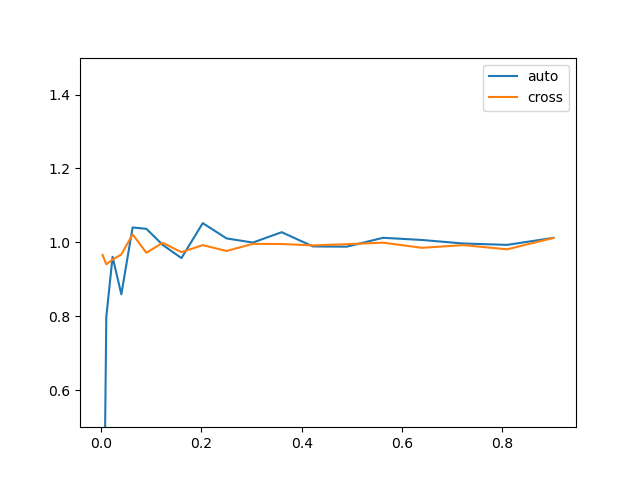

In [ ]:
figure()
plot(gains*gains, gain_auto[0,:n_gains]/1e5/(gains*gains), label='auto')  
plot(gains*gains, gain_cross_no_quant[0,:n_gains]*gain_cross_no_quant[0,:n_gains]/1e10/(gains*gains), label="cross")  #4e10
ylim(0.5,1.5)
legend()

In [ ]:
gain_auto_mean = (gain_auto/1e5/(gains*gains)).mean(axis=0)[:n_gains]
gain_auto_std = (gain_auto/1e5/(gains*gains)).std(axis=0)[:n_gains]
gain_cross_mean = ((gain_cross_no_quant/1e5/(gains))**2).mean(axis=0)[:n_gains]
gain_cross_std = ((gain_cross_no_quant/1e5/(gains))**2).std(axis=0)[:n_gains]

In [ ]:
gain_cross_mean[4]

0.9818065653587371

<IPython.core.display.Javascript object>


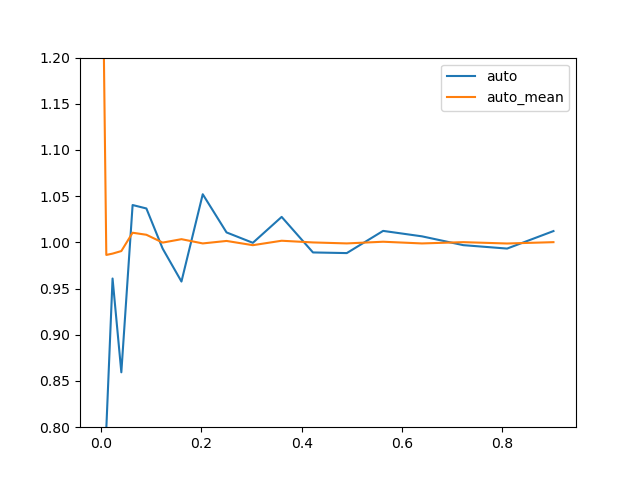

In [ ]:
figure()
plot(gains*gains, gain_auto[0,:n_gains]/1e5/(gains*gains), label='auto') 
plot(gains*gains, gain_auto_mean, label='auto_mean') 

#plot(gains*gains, gain_cross_no_quant[0,:n_gains]*gain_cross_no_quant[0,:n_gains]/1e10/(gains*gains), label="cross")  #4e10
ylim(0.8,1.2)
legend()

<IPython.core.display.Javascript object>


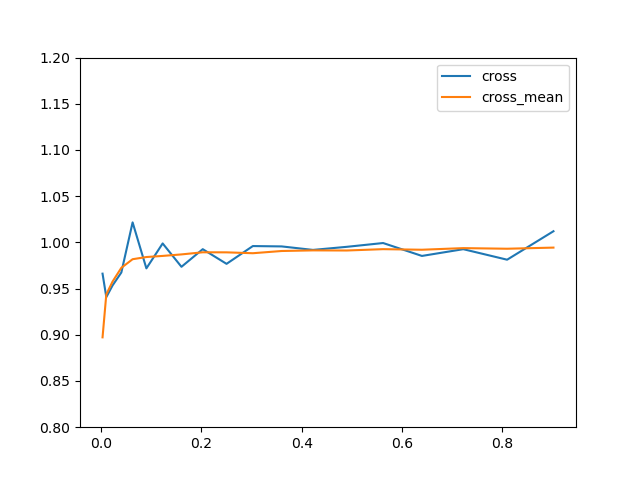

In [ ]:
figure()
plot(gains*gains, gain_cross_no_quant[0,:n_gains]*gain_cross_no_quant[0,:n_gains]/1e10/(gains*gains), label="cross")
plot(gains*gains, gain_cross_mean, label='cross_mean')
#plot(gains*gains, gain_auto[0,:n_gains]/1e5/(gains*gains), label='auto') 
#plot(gains*gains, gain_cross_no_quant[0,:n_gains]*gain_cross_no_quant[0,:n_gains]/1e10/(gains*gains), label="cross")  #4e10
ylim(0.8,1.2)
legend()

<IPython.core.display.Javascript object>


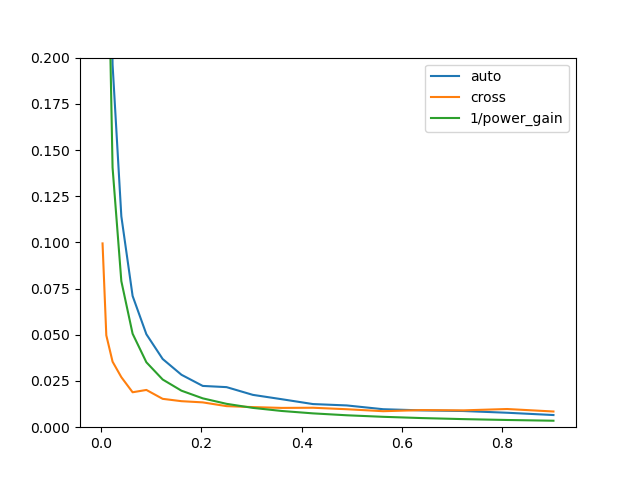

In [ ]:
figure()
plot(gains*gains, gain_auto_std, label="auto")
plot(gains*gains, gain_cross_std, label="cross")
plot(gains*gains, 1/(gains*gains)/316.3, label="1/power_gain")
ylim(0,0.2)
legend()

<IPython.core.display.Javascript object>


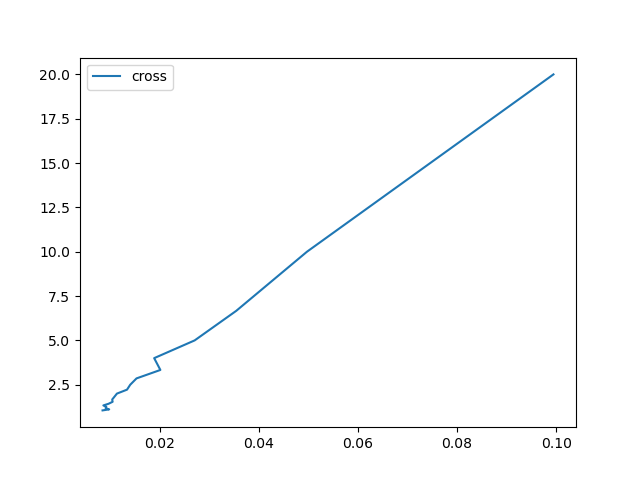

In [ ]:
figure()
#plot(gains*gains, gain_auto_std, label="auto")
plot(gain_cross_std, 1/gains, label="cross")
#ylim(0,0.2)
legend()

<IPython.core.display.Javascript object>


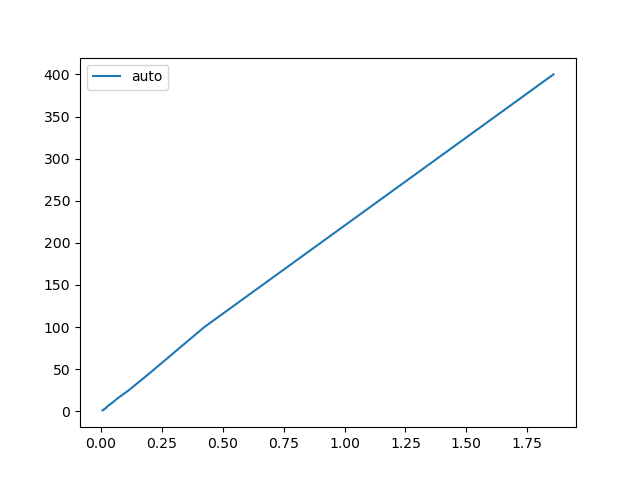

In [ ]:
figure()
plot(gain_auto_std, 1/(gains*gains), label="auto")
#plot(gains, 1/gain_cross_std, label="cross")
#ylim(0,0.2)
legend()

<IPython.core.display.Javascript object>


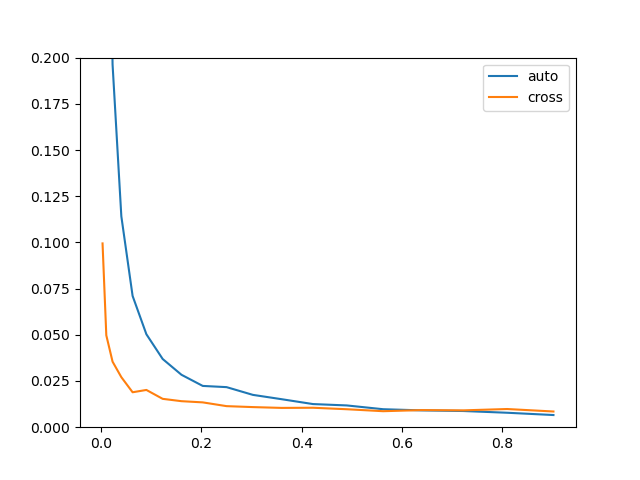

In [ ]:
figure()
plot(gains*gains, gain_auto_std, label="auto")
plot(gains*gains, gain_cross_std, label="cross")
#plot(gains*gains, 1/(gains*gains)/316.3, label="1/power_gain")
ylim(0,0.2)
legend()

<IPython.core.display.Javascript object>


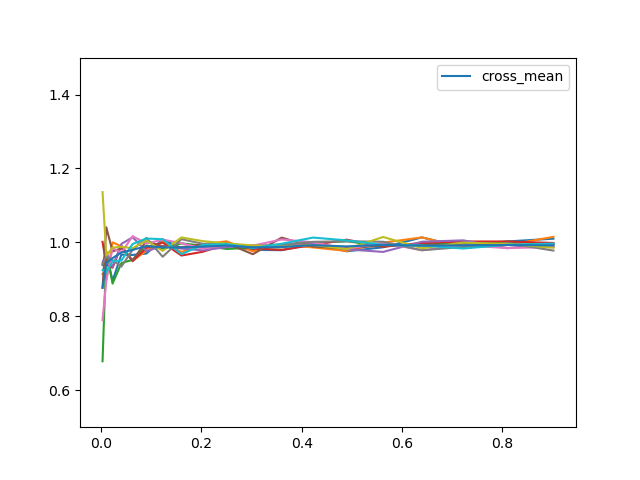

In [ ]:
figure()
for i in range(10):
    plot(gains*gains, gain_cross_no_quant[i,:n_gains]*gain_cross_no_quant[i,:n_gains]/1e10/(gains*gains))
plot(gains*gains, gain_cross_mean*gain_cross_mean, label='cross_mean')
#plot(gains*gains, gain_auto[0,:n_gains]/1e5/(gains*gains), label='auto') 
#plot(gains*gains, gain_cross_no_quant[0,:n_gains]*gain_cross_no_quant[0,:n_gains]/1e10/(gains*gains), label="cross")  #4e10
ylim(0.5,1.5)
legend()

In [ ]:
gains = np.arange(0.05,1,0.05)
n_gains = len(gains)
repeats = 100
stop_time = 50000
gain_cross_no_quant2 = np.zeros((repeats,n_gains))
gain_auto2 = np.zeros((repeats,n_gains))


for i,gain in enumerate(gains):
    for j in np.arange(repeats):
        signal = np.random.normal(0, 1.0/np.sqrt(2), stop_time) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), stop_time)
        noise_term = np.random.normal(0, 1.0/np.sqrt(2), stop_time) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), stop_time)
        noise_term_off = np.random.normal(0, 1.0/np.sqrt(2), stop_time) +1.0j*np.random.normal(0, 1.0/np.sqrt(2), stop_time)
        f_signal_on = gain*signal + noise_term  #this way to make quantization easier
        f_signal_off = noise_term_off
        #q_signal_on = quantizer(f_signal_on, nbits=8)
        #q_signal_off = quantizer(f_signal_off, nbits=8)
        #q_signal_on = f_signal_on
        #q_signal_off = f_signal_off
        auto_corr_on = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(f_signal_on[:stop_time])))
        auto_corr_off = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(f_signal_off[:stop_time])))
        #cross_corr_on = np.fft.ifft(np.fft.fft(q_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
        #cross_corr_off = np.fft.ifft(np.fft.fft(q_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
        cross_corr_on_no_quant = np.fft.ifft(np.fft.fft(f_signal_on[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
        cross_corr_off_no_quant = np.fft.ifft(np.fft.fft(f_signal_off[:stop_time])*np.conjugate(np.fft.fft(signal[:stop_time])))
        gain_cross_no_quant1 = abs(cross_corr_on_no_quant[0]) - abs(cross_corr_off_no_quant[0])
        #gain_cross1 = abs(cross_corr_on[0]) - abs(cross_corr_off[0])
        gain_auto1 = abs(auto_corr_on[0]) - abs(auto_corr_off[0])
        #gain_cross.append(gain_cross1)
        gain_auto2[j,i] = gain_auto1
        gain_cross_no_quant2[j,i] = gain_cross_no_quant1
        print("gain {}, gain auto= {}, gain_cross_no_quant={}".format(gain, gain_auto1, gain_cross_no_quant1))

gain 0.05, gain auto= 256.11310148605844, gain_cross_no_quant=2579.596292084006
gain 0.05, gain auto= -88.38049546201364, gain_cross_no_quant=2336.0677254648926
gain 0.05, gain auto= 21.25512535465532, gain_cross_no_quant=2449.853114006301
gain 0.05, gain auto= 273.85172192548634, gain_cross_no_quant=2191.3542637096584
gain 0.05, gain auto= 95.31059466626175, gain_cross_no_quant=2353.6800050172783
gain 0.05, gain auto= -76.2668502675806, gain_cross_no_quant=2426.816520182322
gain 0.05, gain auto= 270.0168070434156, gain_cross_no_quant=2294.151840759522
gain 0.05, gain auto= -318.12265382596524, gain_cross_no_quant=2270.3237226689116
gain 0.05, gain auto= 310.6928010192496, gain_cross_no_quant=2060.5766022996563
gain 0.05, gain auto= 574.7088019872754, gain_cross_no_quant=2751.91227543587
gain 0.05, gain auto= -456.79538223135023, gain_cross_no_quant=2377.2918654185983
gain 0.05, gain auto= -240.9020650970051, gain_cross_no_quant=2509.8288525431844
gain 0.05, gain auto= 137.390923636383

gain 0.1, gain auto= 578.598107893682, gain_cross_no_quant=4830.289642634739
gain 0.1, gain auto= -213.08726593603205, gain_cross_no_quant=4669.413848006257
gain 0.1, gain auto= 329.33353897134657, gain_cross_no_quant=5116.827695692576
gain 0.1, gain auto= 631.8207629067838, gain_cross_no_quant=4925.65584344159
gain 0.1, gain auto= 304.2150931385913, gain_cross_no_quant=4848.001596449421
gain 0.1, gain auto= -6.458063870770275, gain_cross_no_quant=4790.875259058619
gain 0.1, gain auto= 387.83758912445046, gain_cross_no_quant=4800.085397538407
gain 0.1, gain auto= 1297.6240486763636, gain_cross_no_quant=5238.1888511600155
gain 0.1, gain auto= 691.9292250459475, gain_cross_no_quant=4821.780070523504
gain 0.1, gain auto= 1082.1048308359532, gain_cross_no_quant=4744.294952329287
gain 0.1, gain auto= -42.7697982165555, gain_cross_no_quant=5000.024015850899
gain 0.1, gain auto= 601.6307407861023, gain_cross_no_quant=4611.754173942935
gain 0.1, gain auto= 1187.3590378177978, gain_cross_no_qua

gain 0.15000000000000002, gain auto= 1352.9805770053354, gain_cross_no_quant=7319.494485062025
gain 0.15000000000000002, gain auto= 1126.2552795848314, gain_cross_no_quant=7270.532176965691
gain 0.15000000000000002, gain auto= 717.8654343111775, gain_cross_no_quant=7365.164707446547
gain 0.15000000000000002, gain auto= 1160.4960333962226, gain_cross_no_quant=7120.503562769052
gain 0.15000000000000002, gain auto= 1307.8283072056583, gain_cross_no_quant=7297.398728200988
gain 0.15000000000000002, gain auto= 907.7284988542015, gain_cross_no_quant=7016.463080991293
gain 0.15000000000000002, gain auto= 1224.261916308904, gain_cross_no_quant=7349.330115957561
gain 0.15000000000000002, gain auto= 1071.3909205666641, gain_cross_no_quant=7363.6845638140985
gain 0.15000000000000002, gain auto= 949.100113737557, gain_cross_no_quant=7414.316674435247
gain 0.15000000000000002, gain auto= 948.7918310612804, gain_cross_no_quant=7070.727561498499
gain 0.15000000000000002, gain auto= 694.4956200390152,

gain 0.2, gain auto= 2143.2714418727483, gain_cross_no_quant=9888.356489992826
gain 0.2, gain auto= 1933.0855051334438, gain_cross_no_quant=9850.648872408112
gain 0.2, gain auto= 2604.1120973630605, gain_cross_no_quant=9646.942067380434
gain 0.2, gain auto= 2026.11565501304, gain_cross_no_quant=9822.680083047328
gain 0.2, gain auto= 2158.5792342475543, gain_cross_no_quant=9762.897044851732
gain 0.2, gain auto= 1901.4628312877176, gain_cross_no_quant=9470.823863778201
gain 0.2, gain auto= 2577.5432844658935, gain_cross_no_quant=10072.96102976947
gain 0.2, gain auto= 1990.1389308570288, gain_cross_no_quant=10076.49012764244
gain 0.2, gain auto= 1677.457006333345, gain_cross_no_quant=9444.325772349734
gain 0.2, gain auto= 1759.53119480217, gain_cross_no_quant=9597.977861749801
gain 0.2, gain auto= 2213.5008200384764, gain_cross_no_quant=9731.871915441114
gain 0.2, gain auto= 1510.0876374647123, gain_cross_no_quant=9852.827328954387
gain 0.2, gain auto= 1852.1820518612367, gain_cross_no_qu

gain 0.25, gain auto= 3136.05189766681, gain_cross_no_quant=12381.048298801266
gain 0.25, gain auto= 3026.979090541441, gain_cross_no_quant=12033.138640662652
gain 0.25, gain auto= 2815.4506551542872, gain_cross_no_quant=12380.059573276523
gain 0.25, gain auto= 2665.0883228925813, gain_cross_no_quant=12058.296375050755
gain 0.25, gain auto= 3942.4633968570342, gain_cross_no_quant=12580.783770984992
gain 0.25, gain auto= 3213.354431926964, gain_cross_no_quant=12576.561346134264
gain 0.25, gain auto= 3718.2369018259196, gain_cross_no_quant=12372.320215303102
gain 0.25, gain auto= 2540.9281487068583, gain_cross_no_quant=12445.475377986346
gain 0.25, gain auto= 3769.543733855746, gain_cross_no_quant=12387.671682607563
gain 0.25, gain auto= 2854.4307278157357, gain_cross_no_quant=12474.601423479944
gain 0.25, gain auto= 3173.8797266610345, gain_cross_no_quant=12265.340550299741
gain 0.25, gain auto= 3313.186341852568, gain_cross_no_quant=12463.554251557322
gain 0.25, gain auto= 3407.2817995

gain 0.3, gain auto= 4289.69650523195, gain_cross_no_quant=15330.127690063922
gain 0.3, gain auto= 5193.150099067701, gain_cross_no_quant=14692.654833477944
gain 0.3, gain auto= 4114.0676176483685, gain_cross_no_quant=14815.296021995597
gain 0.3, gain auto= 5072.13971755877, gain_cross_no_quant=15155.615508739249
gain 0.3, gain auto= 4586.874784588574, gain_cross_no_quant=15009.238561018334
gain 0.3, gain auto= 4811.256297433327, gain_cross_no_quant=14952.827335250813
gain 0.3, gain auto= 4541.863391897248, gain_cross_no_quant=14922.50219929033
gain 0.3, gain auto= 4531.0464952154725, gain_cross_no_quant=14613.99034348935
gain 0.3, gain auto= 4850.439466933909, gain_cross_no_quant=14756.497469429025
gain 0.3, gain auto= 4274.661041678912, gain_cross_no_quant=14733.647043002713
gain 0.3, gain auto= 4219.108072047144, gain_cross_no_quant=15033.213077368722
gain 0.3, gain auto= 4077.3347184887025, gain_cross_no_quant=14927.599628807327
gain 0.3, gain auto= 4223.674688652733, gain_cross_no

gain 0.35000000000000003, gain auto= 6224.020069813931, gain_cross_no_quant=17574.16030225561
gain 0.35000000000000003, gain auto= 6371.729912173083, gain_cross_no_quant=17393.68994775661
gain 0.35000000000000003, gain auto= 6357.2189667257335, gain_cross_no_quant=17609.836161125517
gain 0.35000000000000003, gain auto= 6238.103014532913, gain_cross_no_quant=17373.635738572648
gain 0.35000000000000003, gain auto= 6177.895261972961, gain_cross_no_quant=17290.58842174191
gain 0.35000000000000003, gain auto= 6493.3026467515665, gain_cross_no_quant=17332.009637509804
gain 0.35000000000000003, gain auto= 6026.130800263047, gain_cross_no_quant=17087.481748784492
gain 0.35000000000000003, gain auto= 6414.872537919691, gain_cross_no_quant=17356.137825632268
gain 0.35000000000000003, gain auto= 5989.856749538136, gain_cross_no_quant=17279.168579959514
gain 0.35000000000000003, gain auto= 6486.153643973026, gain_cross_no_quant=17263.06020147684
gain 0.35000000000000003, gain auto= 6269.1378347046

gain 0.4, gain auto= 8336.640794170671, gain_cross_no_quant=19539.78883147623
gain 0.4, gain auto= 8355.279392445198, gain_cross_no_quant=19908.51225776165
gain 0.4, gain auto= 8455.889861663098, gain_cross_no_quant=19811.34015288707
gain 0.4, gain auto= 8163.3578162969425, gain_cross_no_quant=19920.49913529045
gain 0.4, gain auto= 8006.829231825352, gain_cross_no_quant=19907.637642413636
gain 0.4, gain auto= 7747.173225265287, gain_cross_no_quant=19414.733550808494
gain 0.4, gain auto= 7897.834763643696, gain_cross_no_quant=19561.8536777989
gain 0.4, gain auto= 7467.576880945257, gain_cross_no_quant=20076.489819228504
gain 0.4, gain auto= 7768.075795314602, gain_cross_no_quant=19861.265409275657
gain 0.4, gain auto= 8513.644159089112, gain_cross_no_quant=20006.28290654899
gain 0.4, gain auto= 8201.48467555888, gain_cross_no_quant=20044.701070583964
gain 0.4, gain auto= 8393.07905980284, gain_cross_no_quant=19666.579764512153
gain 0.4, gain auto= 8235.826113444753, gain_cross_no_quant=

gain 0.45, gain auto= 9913.248264524918, gain_cross_no_quant=22485.321683012695
gain 0.45, gain auto= 10190.271278782173, gain_cross_no_quant=21979.354633348285
gain 0.45, gain auto= 10724.120265151469, gain_cross_no_quant=22405.357955786167
gain 0.45, gain auto= 10040.047844896711, gain_cross_no_quant=22173.564269363822
gain 0.45, gain auto= 9397.065857781017, gain_cross_no_quant=21892.716757448365
gain 0.45, gain auto= 10176.450947074089, gain_cross_no_quant=22448.27752360985
gain 0.45, gain auto= 9940.236360836258, gain_cross_no_quant=22256.671237476516
gain 0.45, gain auto= 10369.423755110329, gain_cross_no_quant=22429.075572458183
gain 0.45, gain auto= 10568.797147517216, gain_cross_no_quant=22646.300519606866
gain 0.45, gain auto= 9831.842322467324, gain_cross_no_quant=22179.974774685303
gain 0.45, gain auto= 10255.115409887563, gain_cross_no_quant=22177.470311770354
gain 0.45, gain auto= 10000.378340584728, gain_cross_no_quant=22133.624009136962
gain 0.45, gain auto= 9966.093226

gain 0.5, gain auto= 12982.372799830788, gain_cross_no_quant=24915.33436843732
gain 0.5, gain auto= 12192.516087577824, gain_cross_no_quant=24452.74123099988
gain 0.5, gain auto= 12714.738763432739, gain_cross_no_quant=24891.353024850672
gain 0.5, gain auto= 12340.405941316138, gain_cross_no_quant=24838.989693951153
gain 0.5, gain auto= 12588.706306811677, gain_cross_no_quant=24826.128867463394
gain 0.5, gain auto= 12699.867182993257, gain_cross_no_quant=25077.95249941136
gain 0.5, gain auto= 12692.858322027023, gain_cross_no_quant=25008.753882131405
gain 0.5, gain auto= 12724.592287475396, gain_cross_no_quant=24810.397199310686
gain 0.5, gain auto= 11911.491874659703, gain_cross_no_quant=24477.841959610512
gain 0.5, gain auto= 12779.404236250375, gain_cross_no_quant=24973.55469900516
gain 0.5, gain auto= 12144.513114411246, gain_cross_no_quant=24557.701006305622
gain 0.5, gain auto= 12623.35410634261, gain_cross_no_quant=25146.079948218252
gain 0.5, gain auto= 12177.606722605022, gain

gain 0.55, gain auto= 14958.623170731844, gain_cross_no_quant=27444.08558359863
gain 0.55, gain auto= 15082.227113109882, gain_cross_no_quant=27071.835393822286
gain 0.55, gain auto= 14722.693324105632, gain_cross_no_quant=27206.982309019455
gain 0.55, gain auto= 14591.986681111572, gain_cross_no_quant=27157.362574247534
gain 0.55, gain auto= 15155.965765569708, gain_cross_no_quant=27310.048202259888
gain 0.55, gain auto= 15283.77853143985, gain_cross_no_quant=27225.198850988556
gain 0.55, gain auto= 14999.997205871725, gain_cross_no_quant=27211.19220174316
gain 0.55, gain auto= 15150.06732095158, gain_cross_no_quant=27391.392539597255
gain 0.55, gain auto= 15334.327636954447, gain_cross_no_quant=27170.30489696994
gain 0.55, gain auto= 15323.38945902051, gain_cross_no_quant=27772.568429084058
gain 0.55, gain auto= 14759.34062437171, gain_cross_no_quant=27350.24045058079
gain 0.55, gain auto= 15148.491558934002, gain_cross_no_quant=27182.60290664825
gain 0.55, gain auto= 15716.076205047

gain 0.6000000000000001, gain auto= 18125.67050233901, gain_cross_no_quant=29764.526081852608
gain 0.6000000000000001, gain auto= 18122.12522200588, gain_cross_no_quant=29607.993378442883
gain 0.6000000000000001, gain auto= 17957.01102297676, gain_cross_no_quant=29981.89429766127
gain 0.6000000000000001, gain auto= 18507.055922347572, gain_cross_no_quant=29748.746811723104
gain 0.6000000000000001, gain auto= 17986.142095269162, gain_cross_no_quant=29742.78364710167
gain 0.6000000000000001, gain auto= 18376.53429805982, gain_cross_no_quant=29624.791308925338
gain 0.6000000000000001, gain auto= 18088.26403958993, gain_cross_no_quant=29819.144863762624
gain 0.6000000000000001, gain auto= 18148.14668893309, gain_cross_no_quant=29797.84386726528
gain 0.6000000000000001, gain auto= 18293.02468070748, gain_cross_no_quant=29645.95718036612
gain 0.6000000000000001, gain auto= 17648.947967816646, gain_cross_no_quant=29383.098692161257
gain 0.6000000000000001, gain auto= 17027.105378349435, gain_

gain 0.6500000000000001, gain auto= 21230.34510099174, gain_cross_no_quant=32615.390841321994
gain 0.6500000000000001, gain auto= 20887.84251047043, gain_cross_no_quant=32096.705267189325
gain 0.6500000000000001, gain auto= 20956.28071032709, gain_cross_no_quant=32343.852596402266
gain 0.6500000000000001, gain auto= 21568.305862078123, gain_cross_no_quant=32113.041694536325
gain 0.6500000000000001, gain auto= 20227.258421287217, gain_cross_no_quant=31939.796456115826
gain 0.6500000000000001, gain auto= 20212.462555743972, gain_cross_no_quant=31868.794747970453
gain 0.6500000000000001, gain auto= 20710.573395065498, gain_cross_no_quant=32211.47052995937
gain 0.6500000000000001, gain auto= 21129.655535378057, gain_cross_no_quant=32420.195420006265
gain 0.6500000000000001, gain auto= 20401.359025733494, gain_cross_no_quant=32124.63057885797
gain 0.6500000000000001, gain auto= 20774.20063687994, gain_cross_no_quant=32519.800438602826
gain 0.6500000000000001, gain auto= 21235.77214817763, g

gain 0.7000000000000001, gain auto= 24467.65108749095, gain_cross_no_quant=34872.82193670494
gain 0.7000000000000001, gain auto= 24445.72962426405, gain_cross_no_quant=35066.62784500559
gain 0.7000000000000001, gain auto= 24245.87938491509, gain_cross_no_quant=34379.15770927778
gain 0.7000000000000001, gain auto= 25045.588943274604, gain_cross_no_quant=35169.31708717239
gain 0.7000000000000001, gain auto= 24783.722521642507, gain_cross_no_quant=34489.46237377859
gain 0.7000000000000001, gain auto= 24773.692418569794, gain_cross_no_quant=35072.80214377603
gain 0.7000000000000001, gain auto= 24910.312575258962, gain_cross_no_quant=35076.18758814397
gain 0.7000000000000001, gain auto= 24256.706355981776, gain_cross_no_quant=34497.11643612313
gain 0.7000000000000001, gain auto= 24882.29860377466, gain_cross_no_quant=34590.29528111547
gain 0.7000000000000001, gain auto= 23925.72778788414, gain_cross_no_quant=34658.537517256955
gain 0.7000000000000001, gain auto= 23895.37517232701, gain_cros

gain 0.7500000000000001, gain auto= 28199.18356873004, gain_cross_no_quant=37429.161583216126
gain 0.7500000000000001, gain auto= 27807.07438798336, gain_cross_no_quant=37171.17595406927
gain 0.7500000000000001, gain auto= 28094.58560857409, gain_cross_no_quant=37548.506772895904
gain 0.7500000000000001, gain auto= 27982.992237880557, gain_cross_no_quant=37203.48749209514
gain 0.7500000000000001, gain auto= 28301.332177278884, gain_cross_no_quant=37193.09860089944
gain 0.7500000000000001, gain auto= 28239.561906154027, gain_cross_no_quant=37305.62701518762
gain 0.7500000000000001, gain auto= 27823.60936662952, gain_cross_no_quant=37260.35425023984
gain 0.7500000000000001, gain auto= 28679.774951874395, gain_cross_no_quant=37447.808976155466
gain 0.7500000000000001, gain auto= 28476.402615416802, gain_cross_no_quant=37489.40344469465
gain 0.7500000000000001, gain auto= 29452.866885751762, gain_cross_no_quant=37739.404101191874
gain 0.7500000000000001, gain auto= 28949.085998478608, gain

gain 0.8, gain auto= 32850.04297897959, gain_cross_no_quant=40040.33006982811
gain 0.8, gain auto= 32996.182685517, gain_cross_no_quant=39850.80081642373
gain 0.8, gain auto= 31753.546763852457, gain_cross_no_quant=39794.76734101658
gain 0.8, gain auto= 31777.741417641526, gain_cross_no_quant=39596.33911129352
gain 0.8, gain auto= 32509.740630549095, gain_cross_no_quant=39966.5966229828
gain 0.8, gain auto= 31525.20610481769, gain_cross_no_quant=39336.69520510806
gain 0.8, gain auto= 31866.256001862836, gain_cross_no_quant=39439.90176650975
gain 0.8, gain auto= 31362.0183957568, gain_cross_no_quant=39552.61843787085
gain 0.8, gain auto= 31684.849477373682, gain_cross_no_quant=39578.62559497713
gain 0.8, gain auto= 31504.17121402244, gain_cross_no_quant=39649.1723633579
gain 0.8, gain auto= 32008.72026033586, gain_cross_no_quant=39862.1846851888
gain 0.8, gain auto= 31794.615178681444, gain_cross_no_quant=39542.51184202118
gain 0.8, gain auto= 32600.661240689333, gain_cross_no_quant=401

gain 0.8500000000000001, gain auto= 36451.22788133998, gain_cross_no_quant=42354.60927716622
gain 0.8500000000000001, gain auto= 35649.00215652508, gain_cross_no_quant=42384.376345042954
gain 0.8500000000000001, gain auto= 35981.199093948926, gain_cross_no_quant=42402.721454146245
gain 0.8500000000000001, gain auto= 36318.39469489685, gain_cross_no_quant=42360.66554248517
gain 0.8500000000000001, gain auto= 36471.252649925744, gain_cross_no_quant=42335.35690251921
gain 0.8500000000000001, gain auto= 36436.48740418786, gain_cross_no_quant=42479.32628923383
gain 0.8500000000000001, gain auto= 35546.79283892834, gain_cross_no_quant=41869.93852528742
gain 0.8500000000000001, gain auto= 36835.734797633464, gain_cross_no_quant=42105.55690799459
gain 0.8500000000000001, gain auto= 35662.57091404858, gain_cross_no_quant=41709.330917258965
gain 0.8500000000000001, gain auto= 35718.755748210555, gain_cross_no_quant=41970.51514658074
gain 0.8500000000000001, gain auto= 36692.96317820968, gain_cro

gain 0.9000000000000001, gain auto= 40268.465160734835, gain_cross_no_quant=44386.79736229302
gain 0.9000000000000001, gain auto= 40649.52165670576, gain_cross_no_quant=44539.17162055911
gain 0.9000000000000001, gain auto= 40073.63617796282, gain_cross_no_quant=44591.792999721714
gain 0.9000000000000001, gain auto= 39983.9941321683, gain_cross_no_quant=44302.48153941742
gain 0.9000000000000001, gain auto= 40365.240193659396, gain_cross_no_quant=44859.95101475716
gain 0.9000000000000001, gain auto= 39828.21581007953, gain_cross_no_quant=44857.92676274097
gain 0.9000000000000001, gain auto= 40339.56976130111, gain_cross_no_quant=44552.486402377945
gain 0.9000000000000001, gain auto= 40505.2681082597, gain_cross_no_quant=44518.15070709234
gain 0.9000000000000001, gain auto= 40279.394908142356, gain_cross_no_quant=44843.00285258217
gain 0.9000000000000001, gain auto= 40272.24370337417, gain_cross_no_quant=44541.69980378611
gain 0.9000000000000001, gain auto= 39902.35309461166, gain_cross_n

gain 0.9500000000000001, gain auto= 44402.582719023216, gain_cross_no_quant=47034.11758264291
gain 0.9500000000000001, gain auto= 45507.92047845986, gain_cross_no_quant=47522.18894042003
gain 0.9500000000000001, gain auto= 45551.21056026239, gain_cross_no_quant=47454.206525906724
gain 0.9500000000000001, gain auto= 44512.28832226719, gain_cross_no_quant=46897.56069180365
gain 0.9500000000000001, gain auto= 45424.33626472241, gain_cross_no_quant=47454.88716061013
gain 0.9500000000000001, gain auto= 44511.52714011346, gain_cross_no_quant=46581.62585193608
gain 0.9500000000000001, gain auto= 45042.341047946684, gain_cross_no_quant=47489.965530788664
gain 0.9500000000000001, gain auto= 45102.72140911394, gain_cross_no_quant=47501.162255429495
gain 0.9500000000000001, gain auto= 45301.21990664235, gain_cross_no_quant=47493.36746540692
gain 0.9500000000000001, gain auto= 44273.79740905712, gain_cross_no_quant=47091.3123340788
gain 0.9500000000000001, gain auto= 46157.04091429289, gain_cross_

gain 0.9500000000000001, gain auto= 45485.17597797304, gain_cross_no_quant=47536.27253799489
gain 0.9500000000000001, gain auto= 45824.97462256869, gain_cross_no_quant=47133.44196840651
gain 0.9500000000000001, gain auto= 44720.62757246822, gain_cross_no_quant=47129.61070163784
gain 0.9500000000000001, gain auto= 44927.40804468496, gain_cross_no_quant=47218.751223108055
gain 0.9500000000000001, gain auto= 45435.19851247959, gain_cross_no_quant=47186.5097245618
gain 0.9500000000000001, gain auto= 45355.296494529866, gain_cross_no_quant=47563.3448045743
gain 0.9500000000000001, gain auto= 45162.11173611621, gain_cross_no_quant=47584.544865545955
gain 0.9500000000000001, gain auto= 44880.19341619461, gain_cross_no_quant=47126.192299976195
gain 0.9500000000000001, gain auto= 45410.94507914649, gain_cross_no_quant=47504.206906086605
gain 0.9500000000000001, gain auto= 45885.19871340098, gain_cross_no_quant=47491.805657554214


In [ ]:
gain_auto_mean2 = (gain_auto2/stop_time/(gains*gains)).mean(axis=0)
gain_auto_std2 = (gain_auto2/stop_time/(gains*gains)).std(axis=0)
gain_cross_mean2 = ((gain_cross_no_quant2/stop_time/(gains))**2).mean(axis=0)
gain_cross_std2 = ((gain_cross_no_quant2/stop_time/(gains))**2).std(axis=0)

<IPython.core.display.Javascript object>


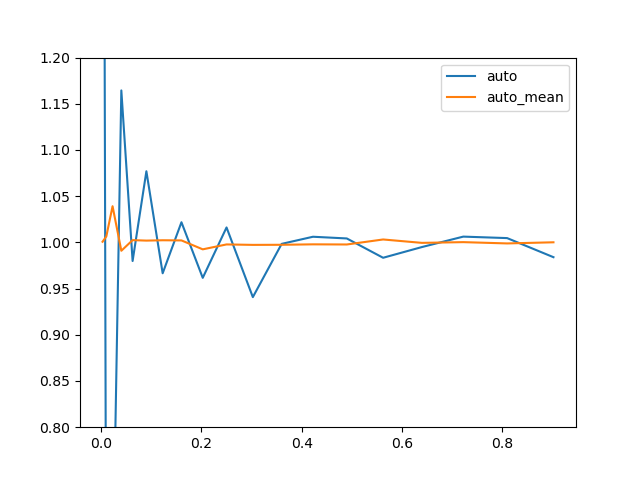

In [ ]:
figure()
plot(gains*gains, gain_auto2[0,:n_gains]/stop_time/(gains*gains), label='auto') 
plot(gains*gains, gain_auto_mean2, label='auto_mean') 

#plot(gains*gains, gain_cross_no_quant[0,:n_gains]*gain_cross_no_quant[0,:n_gains]/1e10/(gains*gains), label="cross")  #4e10
ylim(0.8,1.2)
legend()

<IPython.core.display.Javascript object>


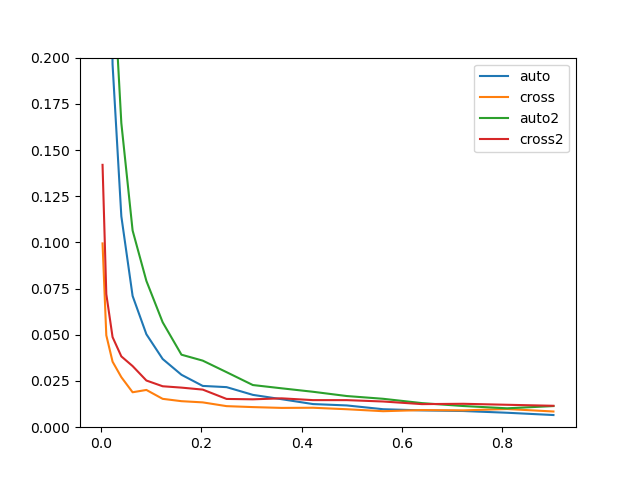

In [ ]:
figure()
plot(gains*gains, gain_auto_std, label="auto")
plot(gains*gains, gain_cross_std, label="cross")
plot(gains*gains, gain_auto_std2, label="auto2")
plot(gains*gains, gain_cross_std2, label="cross2")
#plot(gains*gains, 1/(gains*gains)/316.3, label="1/power_gain")
ylim(0,0.2)
legend()

<ipython-input-314-bd21d6724fc8>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()


<IPython.core.display.Javascript object>


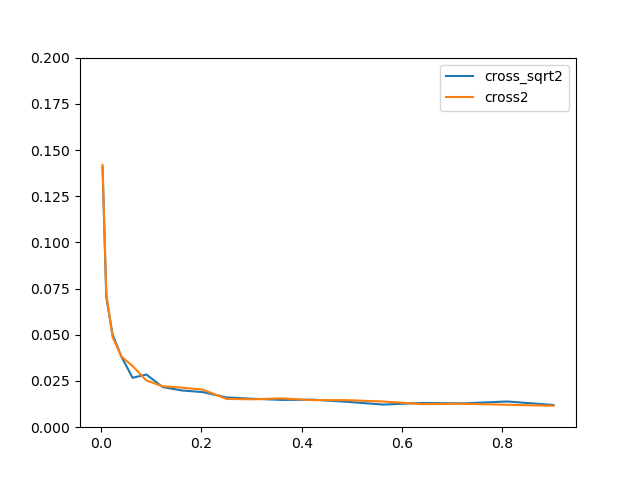

In [ ]:
figure()

plot(gains*gains, gain_cross_std*np.sqrt(2), label="cross_sqrt2")
plot(gains*gains, gain_cross_std2, label="cross2")
#plot(gains*gains, 1/(gains*gains)/316.3, label="1/power_gain")
ylim(0,0.2)
legend()

<IPython.core.display.Javascript object>


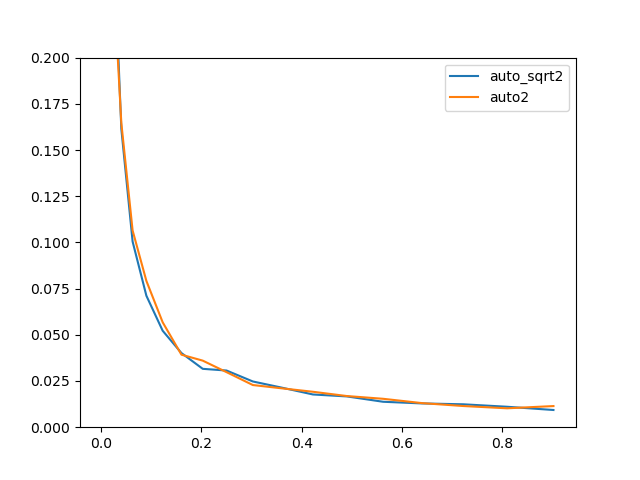

In [ ]:
figure()

plot(gains*gains, gain_auto_std*np.sqrt(2), label="auto_sqrt2")
plot(gains*gains, gain_auto_std2, label="auto2")
#plot(gains*gains, 1/(gains*gains)/316.3, label="1/power_gain")
ylim(0,0.2)
legend()

In [ ]:
sigma_levels_bits = np.arange(0.25,6,0.25)
sigma_levels = 2**sigma_levels_bits

In [ ]:
variances_quantized = []
for sigma1 in sigma_levels:
    signal = np.random.normal(0, sigma1, 500000)
    variances_quantized.append(quantizer(signal,nbits=6).std())

In [ ]:
variances_quantized = np.array(variances_quantized)

<IPython.core.display.Javascript object>


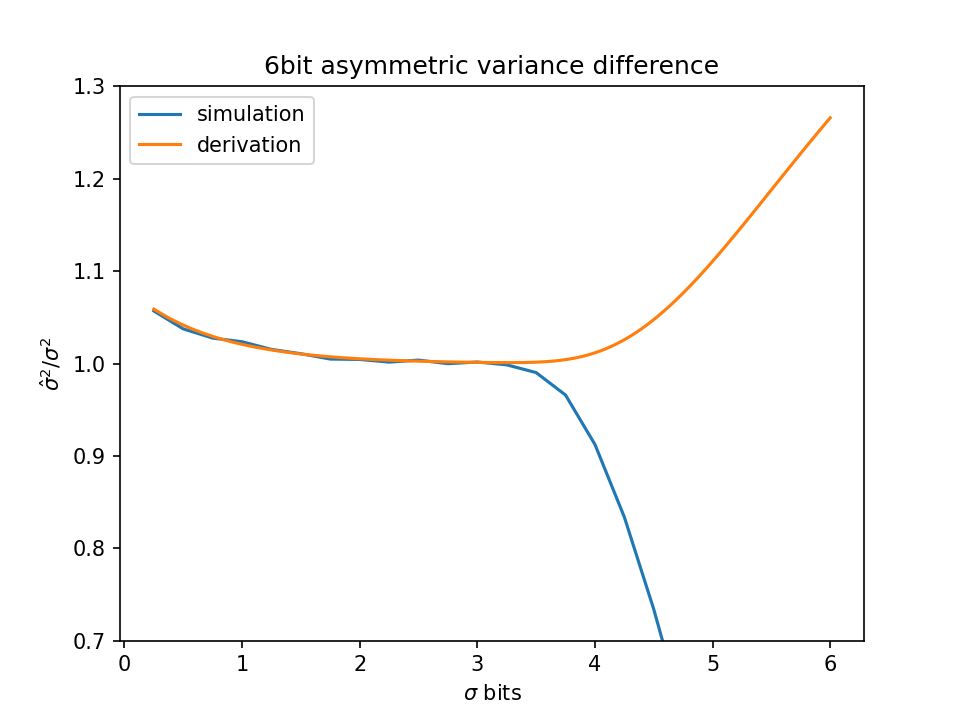

In [ ]:
figure()
plot(sigma_levels_bits, variances_quantized**2/sigma_levels**2, label="simulation")
plot(np.log2(1.0/eps_arr),var_set, label= "derivation")
title("6bit asymmetric variance difference")
ylabel(r'$\hat{\sigma}^2$/$\sigma^2$')
xlabel(r"$\sigma$ bits")
ylim(0.7,1.3)
legend()

In [ ]:
test = np.arange(100)

In [ ]:
test

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
test.sum()

4950

In [ ]:
import numpy as np

In [ ]:
np.sum(test)

4950

In [ ]:
dr=(2/3.14)*(0.5+np.exp((-(m**2)*(ep**2)/2)).sum())**2
#dr=(2/3.14)*(0.5+np.exp((-(m**2)*(ep**2)/2)))**2


In [ ]:
m = 2

m

In [ ]:
m = np.arange(1,32)

In [ ]:
import math

In [ ]:
#nr= (N-0.5)**2- 2.0*(m*erf(m*ep/np.sqrt(2)))
nr= (N-0.5)**2- 2.0*(m*erf(m*ep/np.sqrt(2)).sum())

In [ ]:
np.sqrt(9)

3.0